In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
patch_size = 56
batch_size = 128
latent_dim = 128

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches  -- tensor of stacked patches    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches = []
    
    for file_patch in files_patches:
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patches.append(patch)
        
    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    patches = np.expand_dims(patches, -1)
        
    print("patches shape:", patches.shape)
    
    return patches

In [5]:
x_train = loading_data(train_data_dir)
x_validation = loading_data(validation_data_dir)

patches shape: (64598, 56, 56, 1)
patches shape: (8075, 56, 56, 1)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
encoder_inputs = keras.Input(shape=(patch_size, patch_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 56, 56, 1)         289 

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
#             print(data.shape)
#             print(data[0])
#             print(type(data))
#             print(type(data[0]))
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [11]:
model_version_old = "0.0.0.2"
vae.load_weights(base_dir + '/vae_' + model_version_old + '.h5')

In [13]:
history_callback = vae.fit(x_train, epochs=90 * batch_size, batch_size=batch_size)

model_version = "0.0.0.5"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')

Epoch 1/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7852 - reconstruction_loss: 412.2557 - kl_loss: 1.5295
Epoch 2/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7294 - reconstruction_loss: 412.1993 - kl_loss: 1.5301
Epoch 3/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7531 - reconstruction_loss: 412.2238 - kl_loss: 1.5292
Epoch 4/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.8303 - reconstruction_loss: 412.3005 - kl_loss: 1.5298
Epoch 5/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7558 - reconstruction_loss: 412.2269 - kl_loss: 1.5289
Epoch 6/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7165 - reconstruction_loss: 412.1866 - kl_loss: 1.5299
Epoch 7/11520
505/505 [==============================] - 5s 11ms/step - loss: 413.7822 - reconstruction_loss: 412.2523 - kl_loss: 1.5299
Epoch 8/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7350 - reconstruction_loss: 412.2049 - kl_loss: 1.5301
Epoch 120/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7306 - reconstruction_loss: 412.2001 - kl_loss: 1.5306
Epoch 121/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7368 - reconstruction_loss: 412.2069 - kl_loss: 1.5299
Epoch 122/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7071 - reconstruction_loss: 412.1770 - kl_loss: 1.5301
Epoch 123/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7682 - reconstruction_loss: 412.2385 - kl_loss: 1.5297
Epoch 124/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7272 - reconstruction_loss: 412.1981 - kl_loss: 1.5291
Epoch 125/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7683 - reconstruction_loss: 412.2380 - kl_loss: 1.5304
Epoch 126/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7326 - reconstruction_loss: 412.2035 - kl_loss: 1.5291
Epoch 179/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7911 - reconstruction_loss: 412.2627 - kl_loss: 1.5285
Epoch 180/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7352 - reconstruction_loss: 412.2058 - kl_loss: 1.5295
Epoch 181/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6678 - reconstruction_loss: 412.1376 - kl_loss: 1.5302
Epoch 182/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6977 - reconstruction_loss: 412.1681 - kl_loss: 1.5297
Epoch 183/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7473 - reconstruction_loss: 412.2177 - kl_loss: 1.5295
Epoch 184/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7615 - reconstruction_loss: 412.2315 - kl_loss: 1.5300
Epoch 185/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7487 - reconstruction_loss: 412.2196 - kl_loss: 1.5290
Epoch 238/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7438 - reconstruction_loss: 412.2140 - kl_loss: 1.5298
Epoch 239/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7717 - reconstruction_loss: 412.2414 - kl_loss: 1.5303
Epoch 240/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7509 - reconstruction_loss: 412.2214 - kl_loss: 1.5295
Epoch 241/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7475 - reconstruction_loss: 412.2175 - kl_loss: 1.5301
Epoch 242/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7027 - reconstruction_loss: 412.1737 - kl_loss: 1.5290
Epoch 243/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7884 - reconstruction_loss: 412.2579 - kl_loss: 1.5305
Epoch 244/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7413 - reconstruction_loss: 412.2122 - kl_loss: 1.5291
Epoch 297/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7458 - reconstruction_loss: 412.2157 - kl_loss: 1.5301
Epoch 298/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7242 - reconstruction_loss: 412.1949 - kl_loss: 1.5292
Epoch 299/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7355 - reconstruction_loss: 412.2054 - kl_loss: 1.5301
Epoch 300/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7424 - reconstruction_loss: 412.2134 - kl_loss: 1.5290
Epoch 301/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7570 - reconstruction_loss: 412.2267 - kl_loss: 1.5303
Epoch 302/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6969 - reconstruction_loss: 412.1676 - kl_loss: 1.5293
Epoch 303/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7359 - reconstruction_loss: 412.2053 - kl_loss: 1.5306
Epoch 356/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7069 - reconstruction_loss: 412.1764 - kl_loss: 1.5305
Epoch 357/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7696 - reconstruction_loss: 412.2399 - kl_loss: 1.5297
Epoch 358/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7340 - reconstruction_loss: 412.2034 - kl_loss: 1.5306
Epoch 359/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7447 - reconstruction_loss: 412.2143 - kl_loss: 1.5304
Epoch 360/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7649 - reconstruction_loss: 412.2351 - kl_loss: 1.5299
Epoch 361/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7576 - reconstruction_loss: 412.2283 - kl_loss: 1.5293
Epoch 362/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7327 - reconstruction_loss: 412.2031 - kl_loss: 1.5296
Epoch 415/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7292 - reconstruction_loss: 412.1996 - kl_loss: 1.5296
Epoch 416/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7161 - reconstruction_loss: 412.1848 - kl_loss: 1.5313
Epoch 417/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7607 - reconstruction_loss: 412.2316 - kl_loss: 1.5291
Epoch 418/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7293 - reconstruction_loss: 412.2003 - kl_loss: 1.5291
Epoch 419/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7579 - reconstruction_loss: 412.2279 - kl_loss: 1.5299
Epoch 420/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7324 - reconstruction_loss: 412.2018 - kl_loss: 1.5306
Epoch 421/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7162 - reconstruction_loss: 412.1846 - kl_loss: 1.5316
Epoch 474/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7042 - reconstruction_loss: 412.1747 - kl_loss: 1.5295
Epoch 475/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7412 - reconstruction_loss: 412.2111 - kl_loss: 1.5301
Epoch 476/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6871 - reconstruction_loss: 412.1566 - kl_loss: 1.5305
Epoch 477/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7628 - reconstruction_loss: 412.2339 - kl_loss: 1.5289
Epoch 478/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7018 - reconstruction_loss: 412.1717 - kl_loss: 1.5301
Epoch 479/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7583 - reconstruction_loss: 412.2291 - kl_loss: 1.5292
Epoch 480/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7417 - reconstruction_loss: 412.2123 - kl_loss: 1.5293
Epoch 533/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7066 - reconstruction_loss: 412.1766 - kl_loss: 1.5300
Epoch 534/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7510 - reconstruction_loss: 412.2214 - kl_loss: 1.5296
Epoch 535/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7563 - reconstruction_loss: 412.2266 - kl_loss: 1.5297
Epoch 536/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7699 - reconstruction_loss: 412.2403 - kl_loss: 1.5297
Epoch 537/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7260 - reconstruction_loss: 412.1963 - kl_loss: 1.5297
Epoch 538/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7886 - reconstruction_loss: 412.2585 - kl_loss: 1.5301
Epoch 539/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7526 - reconstruction_loss: 412.2226 - kl_loss: 1.5300
Epoch 592/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7886 - reconstruction_loss: 412.2587 - kl_loss: 1.5298
Epoch 593/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7754 - reconstruction_loss: 412.2458 - kl_loss: 1.5297
Epoch 594/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7474 - reconstruction_loss: 412.2177 - kl_loss: 1.5297
Epoch 595/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7337 - reconstruction_loss: 412.2043 - kl_loss: 1.5294
Epoch 596/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7495 - reconstruction_loss: 412.2203 - kl_loss: 1.5293
Epoch 597/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7171 - reconstruction_loss: 412.1865 - kl_loss: 1.5307
Epoch 598/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.8121 - reconstruction_loss: 412.2821 - kl_loss: 1.5300
Epoch 651/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7346 - reconstruction_loss: 412.2048 - kl_loss: 1.5298
Epoch 652/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7792 - reconstruction_loss: 412.2487 - kl_loss: 1.5304
Epoch 653/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7097 - reconstruction_loss: 412.1790 - kl_loss: 1.5306
Epoch 654/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7325 - reconstruction_loss: 412.2025 - kl_loss: 1.5300
Epoch 655/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7281 - reconstruction_loss: 412.1988 - kl_loss: 1.5293
Epoch 656/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7649 - reconstruction_loss: 412.2355 - kl_loss: 1.5294
Epoch 657/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7341 - reconstruction_loss: 412.2043 - kl_loss: 1.5298
Epoch 710/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7089 - reconstruction_loss: 412.1800 - kl_loss: 1.5289
Epoch 711/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7784 - reconstruction_loss: 412.2480 - kl_loss: 1.5303
Epoch 712/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7196 - reconstruction_loss: 412.1902 - kl_loss: 1.5294
Epoch 713/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7631 - reconstruction_loss: 412.2337 - kl_loss: 1.5294
Epoch 714/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7448 - reconstruction_loss: 412.2142 - kl_loss: 1.5306
Epoch 715/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7262 - reconstruction_loss: 412.1965 - kl_loss: 1.5297
Epoch 716/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7924 - reconstruction_loss: 412.2629 - kl_loss: 1.5294
Epoch 769/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7164 - reconstruction_loss: 412.1864 - kl_loss: 1.5300
Epoch 770/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7066 - reconstruction_loss: 412.1766 - kl_loss: 1.5300
Epoch 771/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7848 - reconstruction_loss: 412.2553 - kl_loss: 1.5296
Epoch 772/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7143 - reconstruction_loss: 412.1838 - kl_loss: 1.5305
Epoch 773/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7354 - reconstruction_loss: 412.2041 - kl_loss: 1.5313
Epoch 774/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7543 - reconstruction_loss: 412.2231 - kl_loss: 1.5312
Epoch 775/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7431 - reconstruction_loss: 412.2141 - kl_loss: 1.5290
Epoch 828/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7869 - reconstruction_loss: 412.2577 - kl_loss: 1.5292
Epoch 829/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7281 - reconstruction_loss: 412.1977 - kl_loss: 1.5304
Epoch 830/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7534 - reconstruction_loss: 412.2229 - kl_loss: 1.5305
Epoch 831/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7198 - reconstruction_loss: 412.1900 - kl_loss: 1.5298
Epoch 832/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.8227 - reconstruction_loss: 412.2923 - kl_loss: 1.5304
Epoch 833/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2383 - kl_loss: 1.5297
Epoch 834/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7309 - reconstruction_loss: 412.2013 - kl_loss: 1.5296
Epoch 887/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7604 - reconstruction_loss: 412.2298 - kl_loss: 1.5306
Epoch 888/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7410 - reconstruction_loss: 412.2108 - kl_loss: 1.5303
Epoch 889/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7625 - reconstruction_loss: 412.2324 - kl_loss: 1.5301
Epoch 890/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7307 - reconstruction_loss: 412.2004 - kl_loss: 1.5303
Epoch 891/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7150 - reconstruction_loss: 412.1841 - kl_loss: 1.5309
Epoch 892/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7982 - reconstruction_loss: 412.2686 - kl_loss: 1.5295
Epoch 893/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7345 - reconstruction_loss: 412.2043 - kl_loss: 1.5301
Epoch 946/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7100 - reconstruction_loss: 412.1792 - kl_loss: 1.5308
Epoch 947/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7074 - reconstruction_loss: 412.1776 - kl_loss: 1.5298
Epoch 948/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7170 - reconstruction_loss: 412.1872 - kl_loss: 1.5298
Epoch 949/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7041 - reconstruction_loss: 412.1738 - kl_loss: 1.5303
Epoch 950/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7500 - reconstruction_loss: 412.2198 - kl_loss: 1.5302
Epoch 951/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7402 - reconstruction_loss: 412.2102 - kl_loss: 1.5300
Epoch 952/11520
505/505 [==================

505/505 [==============================] - 6s 11ms/step - loss: 413.7617 - reconstruction_loss: 412.2316 - kl_loss: 1.5301
Epoch 1005/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7513 - reconstruction_loss: 412.2212 - kl_loss: 1.5301
Epoch 1006/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6872 - reconstruction_loss: 412.1580 - kl_loss: 1.5292
Epoch 1007/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7466 - reconstruction_loss: 412.2158 - kl_loss: 1.5309
Epoch 1008/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7395 - reconstruction_loss: 412.2095 - kl_loss: 1.5300
Epoch 1009/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7533 - reconstruction_loss: 412.2232 - kl_loss: 1.5301
Epoch 1010/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7706 - reconstruction_loss: 412.2404 - kl_loss: 1.5302
Epoch 1011/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7434 - reconstruction_loss: 412.2121 - kl_loss: 1.5314
Epoch 1121/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7629 - reconstruction_loss: 412.2326 - kl_loss: 1.5303
Epoch 1122/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7262 - reconstruction_loss: 412.1952 - kl_loss: 1.5310
Epoch 1123/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7453 - reconstruction_loss: 412.2157 - kl_loss: 1.5296
Epoch 1124/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7063 - reconstruction_loss: 412.1766 - kl_loss: 1.5297
Epoch 1125/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7164 - reconstruction_loss: 412.1864 - kl_loss: 1.5300
Epoch 1126/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6985 - reconstruction_loss: 412.1681 - kl_loss: 1.5303
Epoch 1127/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7357 - reconstruction_loss: 412.2044 - kl_loss: 1.5313
Epoch 1237/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7486 - reconstruction_loss: 412.2190 - kl_loss: 1.5296
Epoch 1238/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7867 - reconstruction_loss: 412.2568 - kl_loss: 1.5299
Epoch 1239/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7761 - reconstruction_loss: 412.2464 - kl_loss: 1.5296
Epoch 1240/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7529 - reconstruction_loss: 412.2226 - kl_loss: 1.5303
Epoch 1241/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7628 - reconstruction_loss: 412.2329 - kl_loss: 1.5299
Epoch 1242/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7644 - reconstruction_loss: 412.2343 - kl_loss: 1.5301
Epoch 1243/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7113 - reconstruction_loss: 412.1812 - kl_loss: 1.5302
Epoch 1353/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7175 - reconstruction_loss: 412.1875 - kl_loss: 1.5300
Epoch 1354/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7233 - reconstruction_loss: 412.1936 - kl_loss: 1.5297
Epoch 1355/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7164 - reconstruction_loss: 412.1858 - kl_loss: 1.5306
Epoch 1356/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7430 - reconstruction_loss: 412.2133 - kl_loss: 1.5297
Epoch 1357/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7720 - reconstruction_loss: 412.2418 - kl_loss: 1.5301
Epoch 1358/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7270 - reconstruction_loss: 412.1971 - kl_loss: 1.5300
Epoch 1359/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6609 - reconstruction_loss: 412.1310 - kl_loss: 1.5299
Epoch 1469/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7303 - reconstruction_loss: 412.1998 - kl_loss: 1.5305
Epoch 1470/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6734 - reconstruction_loss: 412.1433 - kl_loss: 1.5301
Epoch 1471/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7469 - reconstruction_loss: 412.2166 - kl_loss: 1.5304
Epoch 1472/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7964 - reconstruction_loss: 412.2661 - kl_loss: 1.5303
Epoch 1473/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7331 - reconstruction_loss: 412.2026 - kl_loss: 1.5305
Epoch 1474/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6588 - reconstruction_loss: 412.1280 - kl_loss: 1.5308
Epoch 1475/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7152 - reconstruction_loss: 412.1850 - kl_loss: 1.5302
Epoch 1585/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7993 - reconstruction_loss: 412.2695 - kl_loss: 1.5298
Epoch 1586/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7292 - reconstruction_loss: 412.1995 - kl_loss: 1.5297
Epoch 1587/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7349 - reconstruction_loss: 412.2038 - kl_loss: 1.5311
Epoch 1588/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7299 - reconstruction_loss: 412.1994 - kl_loss: 1.5305
Epoch 1589/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7109 - reconstruction_loss: 412.1818 - kl_loss: 1.5291
Epoch 1590/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7392 - reconstruction_loss: 412.2090 - kl_loss: 1.5302
Epoch 1591/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7565 - reconstruction_loss: 412.2266 - kl_loss: 1.5300
Epoch 1701/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7632 - reconstruction_loss: 412.2328 - kl_loss: 1.5304
Epoch 1702/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7227 - reconstruction_loss: 412.1915 - kl_loss: 1.5312
Epoch 1703/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7411 - reconstruction_loss: 412.2115 - kl_loss: 1.5296
Epoch 1704/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7171 - reconstruction_loss: 412.1865 - kl_loss: 1.5306
Epoch 1705/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7387 - reconstruction_loss: 412.2090 - kl_loss: 1.5297
Epoch 1706/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7604 - reconstruction_loss: 412.2299 - kl_loss: 1.5305
Epoch 1707/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7218 - reconstruction_loss: 412.1909 - kl_loss: 1.5309
Epoch 1817/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6959 - reconstruction_loss: 412.1655 - kl_loss: 1.5303
Epoch 1818/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7632 - reconstruction_loss: 412.2326 - kl_loss: 1.5306
Epoch 1819/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6913 - reconstruction_loss: 412.1609 - kl_loss: 1.5304
Epoch 1820/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6991 - reconstruction_loss: 412.1694 - kl_loss: 1.5298
Epoch 1821/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7445 - reconstruction_loss: 412.2140 - kl_loss: 1.5305
Epoch 1822/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7087 - reconstruction_loss: 412.1775 - kl_loss: 1.5312
Epoch 1823/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7016 - reconstruction_loss: 412.1721 - kl_loss: 1.5295
Epoch 1933/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7016 - reconstruction_loss: 412.1722 - kl_loss: 1.5294
Epoch 1934/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7294 - reconstruction_loss: 412.1995 - kl_loss: 1.5299
Epoch 1935/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7370 - reconstruction_loss: 412.2065 - kl_loss: 1.5304
Epoch 1936/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7239 - reconstruction_loss: 412.1933 - kl_loss: 1.5306
Epoch 1937/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7700 - reconstruction_loss: 412.2391 - kl_loss: 1.5309
Epoch 1938/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7427 - reconstruction_loss: 412.2123 - kl_loss: 1.5303
Epoch 1939/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7248 - reconstruction_loss: 412.1929 - kl_loss: 1.5319
Epoch 2049/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.8022 - reconstruction_loss: 412.2710 - kl_loss: 1.5312
Epoch 2050/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7530 - reconstruction_loss: 412.2239 - kl_loss: 1.5291
Epoch 2051/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7011 - reconstruction_loss: 412.1713 - kl_loss: 1.5299
Epoch 2052/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7410 - reconstruction_loss: 412.2106 - kl_loss: 1.5304
Epoch 2053/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7384 - reconstruction_loss: 412.2077 - kl_loss: 1.5306
Epoch 2054/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6862 - reconstruction_loss: 412.1562 - kl_loss: 1.5300
Epoch 2055/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7771 - reconstruction_loss: 412.2463 - kl_loss: 1.5308
Epoch 2165/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7456 - reconstruction_loss: 412.2161 - kl_loss: 1.5295
Epoch 2166/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7430 - reconstruction_loss: 412.2122 - kl_loss: 1.5308
Epoch 2167/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7072 - reconstruction_loss: 412.1767 - kl_loss: 1.5304
Epoch 2168/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6980 - reconstruction_loss: 412.1665 - kl_loss: 1.5315
Epoch 2169/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7074 - reconstruction_loss: 412.1768 - kl_loss: 1.5306
Epoch 2170/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7544 - reconstruction_loss: 412.2239 - kl_loss: 1.5305
Epoch 2171/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7510 - reconstruction_loss: 412.2206 - kl_loss: 1.5304
Epoch 2281/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7176 - reconstruction_loss: 412.1870 - kl_loss: 1.5306
Epoch 2282/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7859 - reconstruction_loss: 412.2561 - kl_loss: 1.5298
Epoch 2283/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7848 - reconstruction_loss: 412.2541 - kl_loss: 1.5307
Epoch 2284/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7225 - reconstruction_loss: 412.1927 - kl_loss: 1.5298
Epoch 2285/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7037 - reconstruction_loss: 412.1731 - kl_loss: 1.5305
Epoch 2286/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7836 - reconstruction_loss: 412.2526 - kl_loss: 1.5309
Epoch 2287/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6978 - reconstruction_loss: 412.1655 - kl_loss: 1.5323
Epoch 2397/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7079 - reconstruction_loss: 412.1782 - kl_loss: 1.5297
Epoch 2398/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7606 - reconstruction_loss: 412.2304 - kl_loss: 1.5302
Epoch 2399/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7641 - reconstruction_loss: 412.2333 - kl_loss: 1.5309
Epoch 2400/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7412 - reconstruction_loss: 412.2111 - kl_loss: 1.5301
Epoch 2401/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7159 - reconstruction_loss: 412.1853 - kl_loss: 1.5306
Epoch 2402/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7854 - reconstruction_loss: 412.2541 - kl_loss: 1.5313
Epoch 2403/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7476 - reconstruction_loss: 412.2177 - kl_loss: 1.5299
Epoch 2513/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6994 - reconstruction_loss: 412.1690 - kl_loss: 1.5304
Epoch 2514/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7338 - reconstruction_loss: 412.2033 - kl_loss: 1.5304
Epoch 2515/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7689 - reconstruction_loss: 412.2383 - kl_loss: 1.5306
Epoch 2516/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7182 - reconstruction_loss: 412.1876 - kl_loss: 1.5307
Epoch 2517/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7152 - reconstruction_loss: 412.1857 - kl_loss: 1.5295
Epoch 2518/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2380 - kl_loss: 1.5300
Epoch 2519/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7313 - reconstruction_loss: 412.2000 - kl_loss: 1.5313
Epoch 2629/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6994 - reconstruction_loss: 412.1685 - kl_loss: 1.5309
Epoch 2630/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6823 - reconstruction_loss: 412.1511 - kl_loss: 1.5312
Epoch 2631/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7593 - reconstruction_loss: 412.2287 - kl_loss: 1.5305
Epoch 2632/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7408 - reconstruction_loss: 412.2106 - kl_loss: 1.5302
Epoch 2633/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7316 - reconstruction_loss: 412.2010 - kl_loss: 1.5306
Epoch 2634/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7653 - reconstruction_loss: 412.2343 - kl_loss: 1.5311
Epoch 2635/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7293 - reconstruction_loss: 412.1987 - kl_loss: 1.5305
Epoch 2745/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6866 - reconstruction_loss: 412.1561 - kl_loss: 1.5305
Epoch 2746/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7776 - reconstruction_loss: 412.2471 - kl_loss: 1.5305
Epoch 2747/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7341 - reconstruction_loss: 412.2039 - kl_loss: 1.5302
Epoch 2748/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6896 - reconstruction_loss: 412.1587 - kl_loss: 1.5308
Epoch 2749/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7040 - reconstruction_loss: 412.1742 - kl_loss: 1.5298
Epoch 2750/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6800 - reconstruction_loss: 412.1483 - kl_loss: 1.5317
Epoch 2751/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6952 - reconstruction_loss: 412.1642 - kl_loss: 1.5310
Epoch 2861/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7004 - reconstruction_loss: 412.1696 - kl_loss: 1.5308
Epoch 2862/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7233 - reconstruction_loss: 412.1923 - kl_loss: 1.5310
Epoch 2863/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6712 - reconstruction_loss: 412.1400 - kl_loss: 1.5312
Epoch 2864/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7565 - reconstruction_loss: 412.2262 - kl_loss: 1.5304
Epoch 2865/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6988 - reconstruction_loss: 412.1677 - kl_loss: 1.5311
Epoch 2866/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7209 - reconstruction_loss: 412.1912 - kl_loss: 1.5298
Epoch 2867/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6819 - reconstruction_loss: 412.1515 - kl_loss: 1.5304
Epoch 2977/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7803 - reconstruction_loss: 412.2500 - kl_loss: 1.5303
Epoch 2978/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7623 - reconstruction_loss: 412.2317 - kl_loss: 1.5306
Epoch 2979/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7539 - reconstruction_loss: 412.2232 - kl_loss: 1.5306
Epoch 2980/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7657 - reconstruction_loss: 412.2345 - kl_loss: 1.5311
Epoch 2981/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7073 - reconstruction_loss: 412.1767 - kl_loss: 1.5306
Epoch 2982/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7266 - reconstruction_loss: 412.1959 - kl_loss: 1.5307
Epoch 2983/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7231 - reconstruction_loss: 412.1926 - kl_loss: 1.5305
Epoch 3093/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7290 - reconstruction_loss: 412.1982 - kl_loss: 1.5308
Epoch 3094/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7248 - reconstruction_loss: 412.1937 - kl_loss: 1.5311
Epoch 3095/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6938 - reconstruction_loss: 412.1630 - kl_loss: 1.5308
Epoch 3096/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7308 - reconstruction_loss: 412.1997 - kl_loss: 1.5311
Epoch 3097/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7574 - reconstruction_loss: 412.2264 - kl_loss: 1.5310
Epoch 3098/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7113 - reconstruction_loss: 412.1802 - kl_loss: 1.5311
Epoch 3099/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7199 - reconstruction_loss: 412.1889 - kl_loss: 1.5310
Epoch 3209/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7089 - reconstruction_loss: 412.1787 - kl_loss: 1.5303
Epoch 3210/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7133 - reconstruction_loss: 412.1825 - kl_loss: 1.5308
Epoch 3211/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6812 - reconstruction_loss: 412.1502 - kl_loss: 1.5310
Epoch 3212/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7422 - reconstruction_loss: 412.2119 - kl_loss: 1.5303
Epoch 3213/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7466 - reconstruction_loss: 412.2159 - kl_loss: 1.5307
Epoch 3214/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7717 - reconstruction_loss: 412.2405 - kl_loss: 1.5311
Epoch 3215/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7491 - reconstruction_loss: 412.2190 - kl_loss: 1.5301
Epoch 3325/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7225 - reconstruction_loss: 412.1920 - kl_loss: 1.5306
Epoch 3326/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7591 - reconstruction_loss: 412.2285 - kl_loss: 1.5306
Epoch 3327/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7274 - reconstruction_loss: 412.1956 - kl_loss: 1.5317
Epoch 3328/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7329 - reconstruction_loss: 412.2027 - kl_loss: 1.5303
Epoch 3329/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7882 - reconstruction_loss: 412.2579 - kl_loss: 1.5303
Epoch 3330/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7561 - reconstruction_loss: 412.2249 - kl_loss: 1.5312
Epoch 3331/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7455 - reconstruction_loss: 412.2141 - kl_loss: 1.5314
Epoch 3441/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7002 - reconstruction_loss: 412.1703 - kl_loss: 1.5300
Epoch 3442/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7417 - reconstruction_loss: 412.2114 - kl_loss: 1.5303
Epoch 3443/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6937 - reconstruction_loss: 412.1635 - kl_loss: 1.5302
Epoch 3444/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7598 - reconstruction_loss: 412.2290 - kl_loss: 1.5307
Epoch 3445/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6841 - reconstruction_loss: 412.1539 - kl_loss: 1.5303
Epoch 3446/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7512 - reconstruction_loss: 412.2216 - kl_loss: 1.5296
Epoch 3447/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7083 - reconstruction_loss: 412.1781 - kl_loss: 1.5302
Epoch 3557/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7997 - reconstruction_loss: 412.2695 - kl_loss: 1.5302
Epoch 3558/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7135 - reconstruction_loss: 412.1823 - kl_loss: 1.5312
Epoch 3559/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7411 - reconstruction_loss: 412.2105 - kl_loss: 1.5306
Epoch 3560/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7020 - reconstruction_loss: 412.1707 - kl_loss: 1.5313
Epoch 3561/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7008 - reconstruction_loss: 412.1703 - kl_loss: 1.5305
Epoch 3562/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7367 - reconstruction_loss: 412.2057 - kl_loss: 1.5310
Epoch 3563/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7211 - reconstruction_loss: 412.1897 - kl_loss: 1.5315
Epoch 3673/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7139 - reconstruction_loss: 412.1840 - kl_loss: 1.5299
Epoch 3674/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7295 - reconstruction_loss: 412.1988 - kl_loss: 1.5307
Epoch 3675/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7106 - reconstruction_loss: 412.1801 - kl_loss: 1.5305
Epoch 3676/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7464 - reconstruction_loss: 412.2154 - kl_loss: 1.5310
Epoch 3677/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7503 - reconstruction_loss: 412.2199 - kl_loss: 1.5305
Epoch 3678/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7469 - reconstruction_loss: 412.2163 - kl_loss: 1.5306
Epoch 3679/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6748 - reconstruction_loss: 412.1444 - kl_loss: 1.5304
Epoch 3789/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7285 - reconstruction_loss: 412.1989 - kl_loss: 1.5296
Epoch 3790/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7447 - reconstruction_loss: 412.2131 - kl_loss: 1.5316
Epoch 3791/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7773 - reconstruction_loss: 412.2470 - kl_loss: 1.5303
Epoch 3792/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7008 - reconstruction_loss: 412.1694 - kl_loss: 1.5314
Epoch 3793/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7768 - reconstruction_loss: 412.2456 - kl_loss: 1.5311
Epoch 3794/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7148 - reconstruction_loss: 412.1834 - kl_loss: 1.5314
Epoch 3795/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7333 - reconstruction_loss: 412.2030 - kl_loss: 1.5303
Epoch 3905/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6890 - reconstruction_loss: 412.1580 - kl_loss: 1.5310
Epoch 3906/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6964 - reconstruction_loss: 412.1654 - kl_loss: 1.5309
Epoch 3907/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7157 - reconstruction_loss: 412.1846 - kl_loss: 1.5311
Epoch 3908/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7402 - reconstruction_loss: 412.2094 - kl_loss: 1.5307
Epoch 3909/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7125 - reconstruction_loss: 412.1818 - kl_loss: 1.5306
Epoch 3910/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7210 - reconstruction_loss: 412.1907 - kl_loss: 1.5304
Epoch 3911/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7355 - reconstruction_loss: 412.2050 - kl_loss: 1.5306
Epoch 4021/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7189 - reconstruction_loss: 412.1890 - kl_loss: 1.5299
Epoch 4022/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7626 - reconstruction_loss: 412.2313 - kl_loss: 1.5313
Epoch 4023/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6888 - reconstruction_loss: 412.1581 - kl_loss: 1.5307
Epoch 4024/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7753 - reconstruction_loss: 412.2446 - kl_loss: 1.5307
Epoch 4025/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.8105 - reconstruction_loss: 412.2798 - kl_loss: 1.5308
Epoch 4026/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7244 - reconstruction_loss: 412.1932 - kl_loss: 1.5312
Epoch 4027/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7127 - reconstruction_loss: 412.1826 - kl_loss: 1.5301
Epoch 4137/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7360 - reconstruction_loss: 412.2055 - kl_loss: 1.5305
Epoch 4138/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7212 - reconstruction_loss: 412.1901 - kl_loss: 1.5311
Epoch 4139/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7456 - reconstruction_loss: 412.2155 - kl_loss: 1.5301
Epoch 4140/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7129 - reconstruction_loss: 412.1825 - kl_loss: 1.5304
Epoch 4141/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7294 - reconstruction_loss: 412.1984 - kl_loss: 1.5310
Epoch 4142/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7676 - reconstruction_loss: 412.2369 - kl_loss: 1.5307
Epoch 4143/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7505 - reconstruction_loss: 412.2198 - kl_loss: 1.5307
Epoch 4253/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6875 - reconstruction_loss: 412.1566 - kl_loss: 1.5309
Epoch 4254/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7144 - reconstruction_loss: 412.1841 - kl_loss: 1.5303
Epoch 4255/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6782 - reconstruction_loss: 412.1474 - kl_loss: 1.5308
Epoch 4256/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7240 - reconstruction_loss: 412.1941 - kl_loss: 1.5299
Epoch 4257/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7633 - reconstruction_loss: 412.2324 - kl_loss: 1.5309
Epoch 4258/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7373 - reconstruction_loss: 412.2070 - kl_loss: 1.5303
Epoch 4259/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7544 - reconstruction_loss: 412.2230 - kl_loss: 1.5314
Epoch 4369/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7178 - reconstruction_loss: 412.1867 - kl_loss: 1.5311
Epoch 4370/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7386 - reconstruction_loss: 412.2073 - kl_loss: 1.5313
Epoch 4371/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6650 - reconstruction_loss: 412.1343 - kl_loss: 1.5307
Epoch 4372/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7284 - reconstruction_loss: 412.1967 - kl_loss: 1.5317
Epoch 4373/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7835 - reconstruction_loss: 412.2527 - kl_loss: 1.5309
Epoch 4374/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6822 - reconstruction_loss: 412.1500 - kl_loss: 1.5322
Epoch 4375/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7303 - reconstruction_loss: 412.1991 - kl_loss: 1.5313
Epoch 4485/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6673 - reconstruction_loss: 412.1360 - kl_loss: 1.5312
Epoch 4486/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6977 - reconstruction_loss: 412.1671 - kl_loss: 1.5306
Epoch 4487/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.8018 - reconstruction_loss: 412.2715 - kl_loss: 1.5302
Epoch 4488/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7130 - reconstruction_loss: 412.1811 - kl_loss: 1.5318
Epoch 4489/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7123 - reconstruction_loss: 412.1812 - kl_loss: 1.5311
Epoch 4490/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7524 - reconstruction_loss: 412.2216 - kl_loss: 1.5307
Epoch 4491/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7424 - reconstruction_loss: 412.2103 - kl_loss: 1.5321
Epoch 4601/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7079 - reconstruction_loss: 412.1762 - kl_loss: 1.5318
Epoch 4602/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6786 - reconstruction_loss: 412.1481 - kl_loss: 1.5304
Epoch 4603/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7311 - reconstruction_loss: 412.2004 - kl_loss: 1.5307
Epoch 4604/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7216 - reconstruction_loss: 412.1913 - kl_loss: 1.5303
Epoch 4605/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7080 - reconstruction_loss: 412.1768 - kl_loss: 1.5312
Epoch 4606/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7094 - reconstruction_loss: 412.1780 - kl_loss: 1.5314
Epoch 4607/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7603 - reconstruction_loss: 412.2285 - kl_loss: 1.5318
Epoch 4717/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7094 - reconstruction_loss: 412.1786 - kl_loss: 1.5308
Epoch 4718/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7319 - reconstruction_loss: 412.2009 - kl_loss: 1.5310
Epoch 4719/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6745 - reconstruction_loss: 412.1436 - kl_loss: 1.5309
Epoch 4720/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6674 - reconstruction_loss: 412.1359 - kl_loss: 1.5315
Epoch 4721/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7508 - reconstruction_loss: 412.2201 - kl_loss: 1.5307
Epoch 4722/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7804 - reconstruction_loss: 412.2497 - kl_loss: 1.5307
Epoch 4723/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6922 - reconstruction_loss: 412.1610 - kl_loss: 1.5312
Epoch 4833/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7161 - reconstruction_loss: 412.1852 - kl_loss: 1.5308
Epoch 4834/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7464 - reconstruction_loss: 412.2153 - kl_loss: 1.5310
Epoch 4835/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7397 - reconstruction_loss: 412.2096 - kl_loss: 1.5300
Epoch 4836/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7295 - reconstruction_loss: 412.1983 - kl_loss: 1.5312
Epoch 4837/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6936 - reconstruction_loss: 412.1630 - kl_loss: 1.5306
Epoch 4838/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7119 - reconstruction_loss: 412.1814 - kl_loss: 1.5305
Epoch 4839/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6551 - reconstruction_loss: 412.1243 - kl_loss: 1.5308
Epoch 4949/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7399 - reconstruction_loss: 412.2087 - kl_loss: 1.5312
Epoch 4950/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7439 - reconstruction_loss: 412.2133 - kl_loss: 1.5306
Epoch 4951/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6771 - reconstruction_loss: 412.1460 - kl_loss: 1.5311
Epoch 4952/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7281 - reconstruction_loss: 412.1962 - kl_loss: 1.5319
Epoch 4953/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7507 - reconstruction_loss: 412.2186 - kl_loss: 1.5321
Epoch 4954/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7260 - reconstruction_loss: 412.1934 - kl_loss: 1.5326
Epoch 4955/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6629 - reconstruction_loss: 412.1313 - kl_loss: 1.5316
Epoch 5065/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6674 - reconstruction_loss: 412.1370 - kl_loss: 1.5304
Epoch 5066/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6920 - reconstruction_loss: 412.1603 - kl_loss: 1.5317
Epoch 5067/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7180 - reconstruction_loss: 412.1870 - kl_loss: 1.5310
Epoch 5068/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7026 - reconstruction_loss: 412.1712 - kl_loss: 1.5314
Epoch 5069/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7489 - reconstruction_loss: 412.2175 - kl_loss: 1.5313
Epoch 5070/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7565 - reconstruction_loss: 412.2246 - kl_loss: 1.5319
Epoch 5071/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7473 - reconstruction_loss: 412.2159 - kl_loss: 1.5314
Epoch 5181/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7256 - reconstruction_loss: 412.1948 - kl_loss: 1.5308
Epoch 5182/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7472 - reconstruction_loss: 412.2156 - kl_loss: 1.5316
Epoch 5183/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7092 - reconstruction_loss: 412.1780 - kl_loss: 1.5312
Epoch 5184/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7414 - reconstruction_loss: 412.2104 - kl_loss: 1.5310
Epoch 5185/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7102 - reconstruction_loss: 412.1794 - kl_loss: 1.5309
Epoch 5186/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6457 - reconstruction_loss: 412.1147 - kl_loss: 1.5310
Epoch 5187/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7342 - reconstruction_loss: 412.2035 - kl_loss: 1.5307
Epoch 5297/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6972 - reconstruction_loss: 412.1652 - kl_loss: 1.5319
Epoch 5298/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7431 - reconstruction_loss: 412.2122 - kl_loss: 1.5309
Epoch 5299/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7452 - reconstruction_loss: 412.2135 - kl_loss: 1.5317
Epoch 5300/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6823 - reconstruction_loss: 412.1503 - kl_loss: 1.5321
Epoch 5301/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6786 - reconstruction_loss: 412.1478 - kl_loss: 1.5308
Epoch 5302/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7689 - reconstruction_loss: 412.2380 - kl_loss: 1.5309
Epoch 5303/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7197 - reconstruction_loss: 412.1875 - kl_loss: 1.5321
Epoch 5413/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7210 - reconstruction_loss: 412.1890 - kl_loss: 1.5320
Epoch 5414/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6974 - reconstruction_loss: 412.1665 - kl_loss: 1.5309
Epoch 5415/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7766 - reconstruction_loss: 412.2457 - kl_loss: 1.5309
Epoch 5416/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7769 - reconstruction_loss: 412.2444 - kl_loss: 1.5324
Epoch 5417/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7617 - reconstruction_loss: 412.2296 - kl_loss: 1.5321
Epoch 5418/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7719 - reconstruction_loss: 412.2410 - kl_loss: 1.5309
Epoch 5419/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7320 - reconstruction_loss: 412.2002 - kl_loss: 1.5318
Epoch 5529/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6699 - reconstruction_loss: 412.1384 - kl_loss: 1.5315
Epoch 5530/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7220 - reconstruction_loss: 412.1900 - kl_loss: 1.5319
Epoch 5531/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7680 - reconstruction_loss: 412.2371 - kl_loss: 1.5308
Epoch 5532/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6814 - reconstruction_loss: 412.1495 - kl_loss: 1.5319
Epoch 5533/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7238 - reconstruction_loss: 412.1910 - kl_loss: 1.5328
Epoch 5534/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6774 - reconstruction_loss: 412.1455 - kl_loss: 1.5319
Epoch 5535/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6831 - reconstruction_loss: 412.1515 - kl_loss: 1.5317
Epoch 5645/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6853 - reconstruction_loss: 412.1547 - kl_loss: 1.5306
Epoch 5646/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7375 - reconstruction_loss: 412.2061 - kl_loss: 1.5314
Epoch 5647/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6672 - reconstruction_loss: 412.1358 - kl_loss: 1.5314
Epoch 5648/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6665 - reconstruction_loss: 412.1347 - kl_loss: 1.5318
Epoch 5649/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7162 - reconstruction_loss: 412.1846 - kl_loss: 1.5316
Epoch 5650/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7671 - reconstruction_loss: 412.2353 - kl_loss: 1.5319
Epoch 5651/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7510 - reconstruction_loss: 412.2193 - kl_loss: 1.5317
Epoch 5761/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7289 - reconstruction_loss: 412.1973 - kl_loss: 1.5317
Epoch 5762/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7137 - reconstruction_loss: 412.1825 - kl_loss: 1.5312
Epoch 5763/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7375 - reconstruction_loss: 412.2055 - kl_loss: 1.5320
Epoch 5764/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6922 - reconstruction_loss: 412.1605 - kl_loss: 1.5317
Epoch 5765/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7285 - reconstruction_loss: 412.1975 - kl_loss: 1.5311
Epoch 5766/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6895 - reconstruction_loss: 412.1586 - kl_loss: 1.5309
Epoch 5767/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7097 - reconstruction_loss: 412.1799 - kl_loss: 1.5298
Epoch 5877/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7807 - reconstruction_loss: 412.2510 - kl_loss: 1.5297
Epoch 5878/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7777 - reconstruction_loss: 412.2470 - kl_loss: 1.5308
Epoch 5879/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7426 - reconstruction_loss: 412.2126 - kl_loss: 1.5299
Epoch 5880/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7456 - reconstruction_loss: 412.2167 - kl_loss: 1.5289
Epoch 5881/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7587 - reconstruction_loss: 412.2290 - kl_loss: 1.5296
Epoch 5882/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7382 - reconstruction_loss: 412.2094 - kl_loss: 1.5288
Epoch 5883/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7036 - reconstruction_loss: 412.1740 - kl_loss: 1.5296
Epoch 5993/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7419 - reconstruction_loss: 412.2122 - kl_loss: 1.5296
Epoch 5994/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7706 - reconstruction_loss: 412.2412 - kl_loss: 1.5294
Epoch 5995/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7100 - reconstruction_loss: 412.1804 - kl_loss: 1.5295
Epoch 5996/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7285 - reconstruction_loss: 412.1984 - kl_loss: 1.5300
Epoch 5997/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7509 - reconstruction_loss: 412.2204 - kl_loss: 1.5305
Epoch 5998/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7342 - reconstruction_loss: 412.2035 - kl_loss: 1.5308
Epoch 5999/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7086 - reconstruction_loss: 412.1775 - kl_loss: 1.5310
Epoch 6109/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7182 - reconstruction_loss: 412.1885 - kl_loss: 1.5297
Epoch 6110/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7490 - reconstruction_loss: 412.2197 - kl_loss: 1.5292
Epoch 6111/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7062 - reconstruction_loss: 412.1759 - kl_loss: 1.5304
Epoch 6112/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7279 - reconstruction_loss: 412.1975 - kl_loss: 1.5304
Epoch 6113/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7064 - reconstruction_loss: 412.1762 - kl_loss: 1.5302
Epoch 6114/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7542 - reconstruction_loss: 412.2249 - kl_loss: 1.5293
Epoch 6115/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7560 - reconstruction_loss: 412.2256 - kl_loss: 1.5304
Epoch 6225/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6975 - reconstruction_loss: 412.1674 - kl_loss: 1.5301
Epoch 6226/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7588 - reconstruction_loss: 412.2286 - kl_loss: 1.5302
Epoch 6227/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7583 - reconstruction_loss: 412.2287 - kl_loss: 1.5296
Epoch 6228/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7456 - reconstruction_loss: 412.2154 - kl_loss: 1.5303
Epoch 6229/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6756 - reconstruction_loss: 412.1455 - kl_loss: 1.5301
Epoch 6230/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7143 - reconstruction_loss: 412.1834 - kl_loss: 1.5309
Epoch 6231/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7636 - reconstruction_loss: 412.2336 - kl_loss: 1.5300
Epoch 6341/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7816 - reconstruction_loss: 412.2512 - kl_loss: 1.5304
Epoch 6342/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7344 - reconstruction_loss: 412.2036 - kl_loss: 1.5308
Epoch 6343/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7199 - reconstruction_loss: 412.1900 - kl_loss: 1.5299
Epoch 6344/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7579 - reconstruction_loss: 412.2277 - kl_loss: 1.5302
Epoch 6345/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7686 - reconstruction_loss: 412.2380 - kl_loss: 1.5305
Epoch 6346/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7603 - reconstruction_loss: 412.2288 - kl_loss: 1.5315
Epoch 6347/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7193 - reconstruction_loss: 412.1879 - kl_loss: 1.5314
Epoch 6457/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7515 - reconstruction_loss: 412.2212 - kl_loss: 1.5303
Epoch 6458/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7379 - reconstruction_loss: 412.2073 - kl_loss: 1.5306
Epoch 6459/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7174 - reconstruction_loss: 412.1868 - kl_loss: 1.5306
Epoch 6460/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6849 - reconstruction_loss: 412.1542 - kl_loss: 1.5306
Epoch 6461/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6799 - reconstruction_loss: 412.1495 - kl_loss: 1.5305
Epoch 6462/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7033 - reconstruction_loss: 412.1732 - kl_loss: 1.5301
Epoch 6463/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7577 - reconstruction_loss: 412.2274 - kl_loss: 1.5304
Epoch 6573/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7909 - reconstruction_loss: 412.2608 - kl_loss: 1.5301
Epoch 6574/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7100 - reconstruction_loss: 412.1789 - kl_loss: 1.5311
Epoch 6575/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7103 - reconstruction_loss: 412.1797 - kl_loss: 1.5306
Epoch 6576/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7247 - reconstruction_loss: 412.1942 - kl_loss: 1.5305
Epoch 6577/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7527 - reconstruction_loss: 412.2219 - kl_loss: 1.5308
Epoch 6578/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7548 - reconstruction_loss: 412.2236 - kl_loss: 1.5311
Epoch 6579/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7387 - reconstruction_loss: 412.2093 - kl_loss: 1.5294
Epoch 6689/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7493 - reconstruction_loss: 412.2187 - kl_loss: 1.5306
Epoch 6690/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6954 - reconstruction_loss: 412.1642 - kl_loss: 1.5312
Epoch 6691/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7770 - reconstruction_loss: 412.2456 - kl_loss: 1.5314
Epoch 6692/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7282 - reconstruction_loss: 412.1971 - kl_loss: 1.5311
Epoch 6693/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6913 - reconstruction_loss: 412.1602 - kl_loss: 1.5312
Epoch 6694/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7412 - reconstruction_loss: 412.2106 - kl_loss: 1.5305
Epoch 6695/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7260 - reconstruction_loss: 412.1947 - kl_loss: 1.5313
Epoch 6805/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7092 - reconstruction_loss: 412.1782 - kl_loss: 1.5310
Epoch 6806/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7561 - reconstruction_loss: 412.2258 - kl_loss: 1.5303
Epoch 6807/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7068 - reconstruction_loss: 412.1753 - kl_loss: 1.5315
Epoch 6808/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7510 - reconstruction_loss: 412.2194 - kl_loss: 1.5316
Epoch 6809/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7531 - reconstruction_loss: 412.2222 - kl_loss: 1.5309
Epoch 6810/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7633 - reconstruction_loss: 412.2327 - kl_loss: 1.5306
Epoch 6811/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7634 - reconstruction_loss: 412.2316 - kl_loss: 1.5318
Epoch 6921/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7457 - reconstruction_loss: 412.2144 - kl_loss: 1.5313
Epoch 6922/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6982 - reconstruction_loss: 412.1675 - kl_loss: 1.5307
Epoch 6923/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7445 - reconstruction_loss: 412.2128 - kl_loss: 1.5317
Epoch 6924/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7702 - reconstruction_loss: 412.2394 - kl_loss: 1.5308
Epoch 6925/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7258 - reconstruction_loss: 412.1958 - kl_loss: 1.5300
Epoch 6926/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7233 - reconstruction_loss: 412.1931 - kl_loss: 1.5302
Epoch 6927/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7472 - reconstruction_loss: 412.2163 - kl_loss: 1.5310
Epoch 7037/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6929 - reconstruction_loss: 412.1616 - kl_loss: 1.5313
Epoch 7038/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7834 - reconstruction_loss: 412.2528 - kl_loss: 1.5307
Epoch 7039/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7356 - reconstruction_loss: 412.2048 - kl_loss: 1.5308
Epoch 7040/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7272 - reconstruction_loss: 412.1963 - kl_loss: 1.5308
Epoch 7041/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6807 - reconstruction_loss: 412.1497 - kl_loss: 1.5309
Epoch 7042/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7170 - reconstruction_loss: 412.1867 - kl_loss: 1.5304
Epoch 7043/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7311 - reconstruction_loss: 412.1995 - kl_loss: 1.5316
Epoch 7153/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7419 - reconstruction_loss: 412.2118 - kl_loss: 1.5301
Epoch 7154/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7303 - reconstruction_loss: 412.1986 - kl_loss: 1.5318
Epoch 7155/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7443 - reconstruction_loss: 412.2141 - kl_loss: 1.5301
Epoch 7156/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7093 - reconstruction_loss: 412.1782 - kl_loss: 1.5311
Epoch 7157/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6940 - reconstruction_loss: 412.1624 - kl_loss: 1.5316
Epoch 7158/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7201 - reconstruction_loss: 412.1902 - kl_loss: 1.5299
Epoch 7159/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7325 - reconstruction_loss: 412.2011 - kl_loss: 1.5314
Epoch 7269/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7120 - reconstruction_loss: 412.1818 - kl_loss: 1.5302
Epoch 7270/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7351 - reconstruction_loss: 412.2036 - kl_loss: 1.5315
Epoch 7271/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7427 - reconstruction_loss: 412.2126 - kl_loss: 1.5301
Epoch 7272/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7392 - reconstruction_loss: 412.2077 - kl_loss: 1.5315
Epoch 7273/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7877 - reconstruction_loss: 412.2559 - kl_loss: 1.5319
Epoch 7274/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7604 - reconstruction_loss: 412.2289 - kl_loss: 1.5316
Epoch 7275/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7132 - reconstruction_loss: 412.1825 - kl_loss: 1.5307
Epoch 7385/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7103 - reconstruction_loss: 412.1789 - kl_loss: 1.5314
Epoch 7386/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7373 - reconstruction_loss: 412.2052 - kl_loss: 1.5321
Epoch 7387/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7749 - reconstruction_loss: 412.2438 - kl_loss: 1.5310
Epoch 7388/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7308 - reconstruction_loss: 412.1994 - kl_loss: 1.5315
Epoch 7389/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6895 - reconstruction_loss: 412.1583 - kl_loss: 1.5312
Epoch 7390/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7456 - reconstruction_loss: 412.2144 - kl_loss: 1.5312
Epoch 7391/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6835 - reconstruction_loss: 412.1528 - kl_loss: 1.5307
Epoch 7501/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7287 - reconstruction_loss: 412.1973 - kl_loss: 1.5314
Epoch 7502/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7407 - reconstruction_loss: 412.2099 - kl_loss: 1.5308
Epoch 7503/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7149 - reconstruction_loss: 412.1839 - kl_loss: 1.5309
Epoch 7504/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7325 - reconstruction_loss: 412.2017 - kl_loss: 1.5309
Epoch 7505/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6650 - reconstruction_loss: 412.1335 - kl_loss: 1.5315
Epoch 7506/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7312 - reconstruction_loss: 412.1997 - kl_loss: 1.5315
Epoch 7507/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6947 - reconstruction_loss: 412.1634 - kl_loss: 1.5313
Epoch 7617/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6969 - reconstruction_loss: 412.1654 - kl_loss: 1.5316
Epoch 7618/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6990 - reconstruction_loss: 412.1674 - kl_loss: 1.5316
Epoch 7619/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7442 - reconstruction_loss: 412.2132 - kl_loss: 1.5310
Epoch 7620/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7290 - reconstruction_loss: 412.1971 - kl_loss: 1.5319
Epoch 7621/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7498 - reconstruction_loss: 412.2182 - kl_loss: 1.5316
Epoch 7622/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7136 - reconstruction_loss: 412.1812 - kl_loss: 1.5324
Epoch 7623/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7695 - reconstruction_loss: 412.2384 - kl_loss: 1.5311
Epoch 7733/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7143 - reconstruction_loss: 412.1819 - kl_loss: 1.5324
Epoch 7734/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7081 - reconstruction_loss: 412.1770 - kl_loss: 1.5311
Epoch 7735/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7594 - reconstruction_loss: 412.2279 - kl_loss: 1.5315
Epoch 7736/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7036 - reconstruction_loss: 412.1717 - kl_loss: 1.5320
Epoch 7737/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7164 - reconstruction_loss: 412.1850 - kl_loss: 1.5313
Epoch 7738/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6942 - reconstruction_loss: 412.1629 - kl_loss: 1.5313
Epoch 7739/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7024 - reconstruction_loss: 412.1712 - kl_loss: 1.5311
Epoch 7849/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7798 - reconstruction_loss: 412.2476 - kl_loss: 1.5322
Epoch 7850/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6928 - reconstruction_loss: 412.1611 - kl_loss: 1.5317
Epoch 7851/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7306 - reconstruction_loss: 412.1993 - kl_loss: 1.5313
Epoch 7852/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6640 - reconstruction_loss: 412.1337 - kl_loss: 1.5303
Epoch 7853/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7581 - reconstruction_loss: 412.2273 - kl_loss: 1.5308
Epoch 7854/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7632 - reconstruction_loss: 412.2310 - kl_loss: 1.5322
Epoch 7855/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7141 - reconstruction_loss: 412.1823 - kl_loss: 1.5318
Epoch 7965/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7500 - reconstruction_loss: 412.2184 - kl_loss: 1.5316
Epoch 7966/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7362 - reconstruction_loss: 412.2045 - kl_loss: 1.5317
Epoch 7967/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7137 - reconstruction_loss: 412.1821 - kl_loss: 1.5316
Epoch 7968/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7003 - reconstruction_loss: 412.1685 - kl_loss: 1.5318
Epoch 7969/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6943 - reconstruction_loss: 412.1631 - kl_loss: 1.5312
Epoch 7970/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6946 - reconstruction_loss: 412.1632 - kl_loss: 1.5314
Epoch 7971/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6797 - reconstruction_loss: 412.1472 - kl_loss: 1.5325
Epoch 8081/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6939 - reconstruction_loss: 412.1629 - kl_loss: 1.5310
Epoch 8082/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7157 - reconstruction_loss: 412.1845 - kl_loss: 1.5312
Epoch 8083/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7705 - reconstruction_loss: 412.2383 - kl_loss: 1.5322
Epoch 8084/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7421 - reconstruction_loss: 412.2101 - kl_loss: 1.5320
Epoch 8085/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7223 - reconstruction_loss: 412.1903 - kl_loss: 1.5319
Epoch 8086/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7469 - reconstruction_loss: 412.2150 - kl_loss: 1.5320
Epoch 8087/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7290 - reconstruction_loss: 412.1973 - kl_loss: 1.5318
Epoch 8197/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7546 - reconstruction_loss: 412.2231 - kl_loss: 1.5315
Epoch 8198/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7073 - reconstruction_loss: 412.1757 - kl_loss: 1.5316
Epoch 8199/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7268 - reconstruction_loss: 412.1946 - kl_loss: 1.5323
Epoch 8200/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6936 - reconstruction_loss: 412.1625 - kl_loss: 1.5311
Epoch 8201/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7087 - reconstruction_loss: 412.1753 - kl_loss: 1.5334
Epoch 8202/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7356 - reconstruction_loss: 412.2041 - kl_loss: 1.5315
Epoch 8203/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6926 - reconstruction_loss: 412.1601 - kl_loss: 1.5325
Epoch 8313/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7050 - reconstruction_loss: 412.1734 - kl_loss: 1.5316
Epoch 8314/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6963 - reconstruction_loss: 412.1639 - kl_loss: 1.5324
Epoch 8315/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7208 - reconstruction_loss: 412.1881 - kl_loss: 1.5328
Epoch 8316/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7005 - reconstruction_loss: 412.1687 - kl_loss: 1.5318
Epoch 8317/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6842 - reconstruction_loss: 412.1526 - kl_loss: 1.5316
Epoch 8318/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7019 - reconstruction_loss: 412.1697 - kl_loss: 1.5322
Epoch 8319/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7705 - reconstruction_loss: 412.2396 - kl_loss: 1.5310
Epoch 8429/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7180 - reconstruction_loss: 412.1859 - kl_loss: 1.5321
Epoch 8430/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7396 - reconstruction_loss: 412.2082 - kl_loss: 1.5314
Epoch 8431/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7272 - reconstruction_loss: 412.1958 - kl_loss: 1.5314
Epoch 8432/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7102 - reconstruction_loss: 412.1781 - kl_loss: 1.5321
Epoch 8433/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6705 - reconstruction_loss: 412.1384 - kl_loss: 1.5321
Epoch 8434/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6839 - reconstruction_loss: 412.1524 - kl_loss: 1.5315
Epoch 8435/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7548 - reconstruction_loss: 412.2226 - kl_loss: 1.5322
Epoch 8545/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6797 - reconstruction_loss: 412.1479 - kl_loss: 1.5318
Epoch 8546/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7455 - reconstruction_loss: 412.2131 - kl_loss: 1.5324
Epoch 8547/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7491 - reconstruction_loss: 412.2170 - kl_loss: 1.5321
Epoch 8548/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6808 - reconstruction_loss: 412.1486 - kl_loss: 1.5323
Epoch 8549/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7342 - reconstruction_loss: 412.2040 - kl_loss: 1.5303
Epoch 8550/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7865 - reconstruction_loss: 412.2542 - kl_loss: 1.5323
Epoch 8551/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7181 - reconstruction_loss: 412.1856 - kl_loss: 1.5325
Epoch 8661/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6915 - reconstruction_loss: 412.1603 - kl_loss: 1.5312
Epoch 8662/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7635 - reconstruction_loss: 412.2312 - kl_loss: 1.5324
Epoch 8663/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7026 - reconstruction_loss: 412.1713 - kl_loss: 1.5312
Epoch 8664/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7186 - reconstruction_loss: 412.1866 - kl_loss: 1.5319
Epoch 8665/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6793 - reconstruction_loss: 412.1475 - kl_loss: 1.5318
Epoch 8666/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7351 - reconstruction_loss: 412.2034 - kl_loss: 1.5316
Epoch 8667/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6995 - reconstruction_loss: 412.1687 - kl_loss: 1.5309
Epoch 8777/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6765 - reconstruction_loss: 412.1443 - kl_loss: 1.5323
Epoch 8778/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7255 - reconstruction_loss: 412.1928 - kl_loss: 1.5327
Epoch 8779/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7752 - reconstruction_loss: 412.2439 - kl_loss: 1.5313
Epoch 8780/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6978 - reconstruction_loss: 412.1655 - kl_loss: 1.5323
Epoch 8781/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7804 - reconstruction_loss: 412.2476 - kl_loss: 1.5328
Epoch 8782/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7152 - reconstruction_loss: 412.1818 - kl_loss: 1.5334
Epoch 8783/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7061 - reconstruction_loss: 412.1746 - kl_loss: 1.5315
Epoch 8893/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7250 - reconstruction_loss: 412.1938 - kl_loss: 1.5312
Epoch 8894/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7162 - reconstruction_loss: 412.1832 - kl_loss: 1.5330
Epoch 8895/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6924 - reconstruction_loss: 412.1601 - kl_loss: 1.5324
Epoch 8896/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7326 - reconstruction_loss: 412.2001 - kl_loss: 1.5325
Epoch 8897/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7394 - reconstruction_loss: 412.2087 - kl_loss: 1.5307
Epoch 8898/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7305 - reconstruction_loss: 412.1987 - kl_loss: 1.5318
Epoch 8899/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7344 - reconstruction_loss: 412.2024 - kl_loss: 1.5320
Epoch 9009/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6981 - reconstruction_loss: 412.1660 - kl_loss: 1.5321
Epoch 9010/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7438 - reconstruction_loss: 412.2119 - kl_loss: 1.5318
Epoch 9011/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7300 - reconstruction_loss: 412.1968 - kl_loss: 1.5332
Epoch 9012/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7532 - reconstruction_loss: 412.2214 - kl_loss: 1.5317
Epoch 9013/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7375 - reconstruction_loss: 412.2056 - kl_loss: 1.5320
Epoch 9014/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7001 - reconstruction_loss: 412.1680 - kl_loss: 1.5321
Epoch 9015/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6798 - reconstruction_loss: 412.1477 - kl_loss: 1.5321
Epoch 9125/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7117 - reconstruction_loss: 412.1795 - kl_loss: 1.5322
Epoch 9126/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6557 - reconstruction_loss: 412.1230 - kl_loss: 1.5327
Epoch 9127/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7270 - reconstruction_loss: 412.1944 - kl_loss: 1.5326
Epoch 9128/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6867 - reconstruction_loss: 412.1547 - kl_loss: 1.5319
Epoch 9129/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7377 - reconstruction_loss: 412.2057 - kl_loss: 1.5319
Epoch 9130/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7077 - reconstruction_loss: 412.1751 - kl_loss: 1.5325
Epoch 9131/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7142 - reconstruction_loss: 412.1813 - kl_loss: 1.5329
Epoch 9241/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7162 - reconstruction_loss: 412.1847 - kl_loss: 1.5315
Epoch 9242/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7336 - reconstruction_loss: 412.2024 - kl_loss: 1.5313
Epoch 9243/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7003 - reconstruction_loss: 412.1678 - kl_loss: 1.5325
Epoch 9244/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7878 - reconstruction_loss: 412.2558 - kl_loss: 1.5320
Epoch 9245/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7449 - reconstruction_loss: 412.2124 - kl_loss: 1.5325
Epoch 9246/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7113 - reconstruction_loss: 412.1778 - kl_loss: 1.5335
Epoch 9247/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7355 - reconstruction_loss: 412.2022 - kl_loss: 1.5333
Epoch 9357/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6997 - reconstruction_loss: 412.1661 - kl_loss: 1.5336
Epoch 9358/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7524 - reconstruction_loss: 412.2201 - kl_loss: 1.5322
Epoch 9359/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6954 - reconstruction_loss: 412.1621 - kl_loss: 1.5333
Epoch 9360/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6968 - reconstruction_loss: 412.1643 - kl_loss: 1.5326
Epoch 9361/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7304 - reconstruction_loss: 412.1984 - kl_loss: 1.5320
Epoch 9362/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6787 - reconstruction_loss: 412.1452 - kl_loss: 1.5335
Epoch 9363/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7282 - reconstruction_loss: 412.1955 - kl_loss: 1.5327
Epoch 9473/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7321 - reconstruction_loss: 412.1997 - kl_loss: 1.5324
Epoch 9474/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7503 - reconstruction_loss: 412.2189 - kl_loss: 1.5314
Epoch 9475/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7088 - reconstruction_loss: 412.1764 - kl_loss: 1.5324
Epoch 9476/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7580 - reconstruction_loss: 412.2267 - kl_loss: 1.5313
Epoch 9477/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7182 - reconstruction_loss: 412.1854 - kl_loss: 1.5328
Epoch 9478/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7083 - reconstruction_loss: 412.1759 - kl_loss: 1.5324
Epoch 9479/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6910 - reconstruction_loss: 412.1578 - kl_loss: 1.5332
Epoch 9589/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7155 - reconstruction_loss: 412.1837 - kl_loss: 1.5319
Epoch 9590/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6920 - reconstruction_loss: 412.1599 - kl_loss: 1.5320
Epoch 9591/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6810 - reconstruction_loss: 412.1493 - kl_loss: 1.5318
Epoch 9592/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6945 - reconstruction_loss: 412.1621 - kl_loss: 1.5324
Epoch 9593/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7131 - reconstruction_loss: 412.1802 - kl_loss: 1.5329
Epoch 9594/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6643 - reconstruction_loss: 412.1319 - kl_loss: 1.5323
Epoch 9595/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7533 - reconstruction_loss: 412.2215 - kl_loss: 1.5318
Epoch 9705/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7207 - reconstruction_loss: 412.1881 - kl_loss: 1.5326
Epoch 9706/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6580 - reconstruction_loss: 412.1255 - kl_loss: 1.5326
Epoch 9707/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7273 - reconstruction_loss: 412.1952 - kl_loss: 1.5321
Epoch 9708/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6867 - reconstruction_loss: 412.1543 - kl_loss: 1.5323
Epoch 9709/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7265 - reconstruction_loss: 412.1928 - kl_loss: 1.5336
Epoch 9710/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6932 - reconstruction_loss: 412.1608 - kl_loss: 1.5324
Epoch 9711/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.7094 - reconstruction_loss: 412.1766 - kl_loss: 1.5328
Epoch 9821/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7119 - reconstruction_loss: 412.1780 - kl_loss: 1.5339
Epoch 9822/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6902 - reconstruction_loss: 412.1569 - kl_loss: 1.5333
Epoch 9823/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6833 - reconstruction_loss: 412.1508 - kl_loss: 1.5325
Epoch 9824/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7326 - reconstruction_loss: 412.2007 - kl_loss: 1.5319
Epoch 9825/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7369 - reconstruction_loss: 412.2042 - kl_loss: 1.5327
Epoch 9826/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7198 - reconstruction_loss: 412.1862 - kl_loss: 1.5336
Epoch 9827/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6735 - reconstruction_loss: 412.1401 - kl_loss: 1.5334
Epoch 9937/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7404 - reconstruction_loss: 412.2085 - kl_loss: 1.5319
Epoch 9938/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7285 - reconstruction_loss: 412.1966 - kl_loss: 1.5320
Epoch 9939/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7392 - reconstruction_loss: 412.2062 - kl_loss: 1.5330
Epoch 9940/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6858 - reconstruction_loss: 412.1534 - kl_loss: 1.5324
Epoch 9941/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7330 - reconstruction_loss: 412.2003 - kl_loss: 1.5327
Epoch 9942/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7091 - reconstruction_loss: 412.1757 - kl_loss: 1.5334
Epoch 9943/11520
505/505 [===========

505/505 [==============================] - 6s 11ms/step - loss: 413.6756 - reconstruction_loss: 412.1432 - kl_loss: 1.5324
Epoch 10053/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7176 - reconstruction_loss: 412.1848 - kl_loss: 1.5328
Epoch 10054/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6728 - reconstruction_loss: 412.1399 - kl_loss: 1.5329
Epoch 10055/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6817 - reconstruction_loss: 412.1502 - kl_loss: 1.5315
Epoch 10056/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7254 - reconstruction_loss: 412.1918 - kl_loss: 1.5336
Epoch 10057/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7180 - reconstruction_loss: 412.1841 - kl_loss: 1.5339
Epoch 10058/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6983 - reconstruction_loss: 412.1653 - kl_loss: 1.5329
Epoch 10059/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7651 - reconstruction_loss: 412.2323 - kl_loss: 1.5328
Epoch 10169/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7085 - reconstruction_loss: 412.1760 - kl_loss: 1.5325
Epoch 10170/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7045 - reconstruction_loss: 412.1712 - kl_loss: 1.5333
Epoch 10171/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7221 - reconstruction_loss: 412.1906 - kl_loss: 1.5315
Epoch 10172/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6985 - reconstruction_loss: 412.1653 - kl_loss: 1.5332
Epoch 10173/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7565 - reconstruction_loss: 412.2238 - kl_loss: 1.5326
Epoch 10174/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7471 - reconstruction_loss: 412.2134 - kl_loss: 1.5337
Epoch 10175/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7547 - reconstruction_loss: 412.2215 - kl_loss: 1.5331
Epoch 10285/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6780 - reconstruction_loss: 412.1461 - kl_loss: 1.5319
Epoch 10286/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7783 - reconstruction_loss: 412.2450 - kl_loss: 1.5333
Epoch 10287/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7282 - reconstruction_loss: 412.1957 - kl_loss: 1.5325
Epoch 10288/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7123 - reconstruction_loss: 412.1792 - kl_loss: 1.5331
Epoch 10289/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6747 - reconstruction_loss: 412.1410 - kl_loss: 1.5337
Epoch 10290/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7557 - reconstruction_loss: 412.2225 - kl_loss: 1.5332
Epoch 10291/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7065 - reconstruction_loss: 412.1730 - kl_loss: 1.5335
Epoch 10401/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7096 - reconstruction_loss: 412.1760 - kl_loss: 1.5336
Epoch 10402/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7458 - reconstruction_loss: 412.2127 - kl_loss: 1.5331
Epoch 10403/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6837 - reconstruction_loss: 412.1503 - kl_loss: 1.5334
Epoch 10404/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7335 - reconstruction_loss: 412.2015 - kl_loss: 1.5320
Epoch 10405/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7286 - reconstruction_loss: 412.1960 - kl_loss: 1.5326
Epoch 10406/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6552 - reconstruction_loss: 412.1219 - kl_loss: 1.5333
Epoch 10407/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.6920 - reconstruction_loss: 412.1581 - kl_loss: 1.5339
Epoch 10517/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6865 - reconstruction_loss: 412.1530 - kl_loss: 1.5335
Epoch 10518/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7112 - reconstruction_loss: 412.1778 - kl_loss: 1.5334
Epoch 10519/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7098 - reconstruction_loss: 412.1766 - kl_loss: 1.5332
Epoch 10520/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7137 - reconstruction_loss: 412.1801 - kl_loss: 1.5335
Epoch 10521/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7499 - reconstruction_loss: 412.2170 - kl_loss: 1.5328
Epoch 10522/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7174 - reconstruction_loss: 412.1848 - kl_loss: 1.5326
Epoch 10523/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.6800 - reconstruction_loss: 412.1476 - kl_loss: 1.5324
Epoch 10633/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6804 - reconstruction_loss: 412.1472 - kl_loss: 1.5333
Epoch 10634/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6946 - reconstruction_loss: 412.1607 - kl_loss: 1.5339
Epoch 10635/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7079 - reconstruction_loss: 412.1754 - kl_loss: 1.5325
Epoch 10636/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6900 - reconstruction_loss: 412.1574 - kl_loss: 1.5326
Epoch 10637/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7255 - reconstruction_loss: 412.1919 - kl_loss: 1.5336
Epoch 10638/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6779 - reconstruction_loss: 412.1448 - kl_loss: 1.5331
Epoch 10639/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7029 - reconstruction_loss: 412.1700 - kl_loss: 1.5329
Epoch 10749/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7566 - reconstruction_loss: 412.2239 - kl_loss: 1.5327
Epoch 10750/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7026 - reconstruction_loss: 412.1696 - kl_loss: 1.5331
Epoch 10751/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7417 - reconstruction_loss: 412.2095 - kl_loss: 1.5322
Epoch 10752/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7603 - reconstruction_loss: 412.2276 - kl_loss: 1.5328
Epoch 10753/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6681 - reconstruction_loss: 412.1340 - kl_loss: 1.5341
Epoch 10754/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6696 - reconstruction_loss: 412.1370 - kl_loss: 1.5326
Epoch 10755/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7626 - reconstruction_loss: 412.2306 - kl_loss: 1.5319
Epoch 10865/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6680 - reconstruction_loss: 412.1355 - kl_loss: 1.5325
Epoch 10866/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7263 - reconstruction_loss: 412.1932 - kl_loss: 1.5331
Epoch 10867/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6796 - reconstruction_loss: 412.1458 - kl_loss: 1.5338
Epoch 10868/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6797 - reconstruction_loss: 412.1457 - kl_loss: 1.5340
Epoch 10869/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7518 - reconstruction_loss: 412.2186 - kl_loss: 1.5332
Epoch 10870/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6741 - reconstruction_loss: 412.1407 - kl_loss: 1.5335
Epoch 10871/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7712 - reconstruction_loss: 412.2396 - kl_loss: 1.5317
Epoch 10981/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7518 - reconstruction_loss: 412.2198 - kl_loss: 1.5319
Epoch 10982/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6574 - reconstruction_loss: 412.1236 - kl_loss: 1.5338
Epoch 10983/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6744 - reconstruction_loss: 412.1404 - kl_loss: 1.5340
Epoch 10984/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7346 - reconstruction_loss: 412.2008 - kl_loss: 1.5338
Epoch 10985/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6574 - reconstruction_loss: 412.1240 - kl_loss: 1.5334
Epoch 10986/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7718 - reconstruction_loss: 412.2382 - kl_loss: 1.5336
Epoch 10987/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.6667 - reconstruction_loss: 412.1335 - kl_loss: 1.5332
Epoch 11097/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7082 - reconstruction_loss: 412.1748 - kl_loss: 1.5334
Epoch 11098/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7064 - reconstruction_loss: 412.1733 - kl_loss: 1.5332
Epoch 11099/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7197 - reconstruction_loss: 412.1862 - kl_loss: 1.5334
Epoch 11100/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6792 - reconstruction_loss: 412.1459 - kl_loss: 1.5333
Epoch 11101/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7566 - reconstruction_loss: 412.2232 - kl_loss: 1.5334
Epoch 11102/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6825 - reconstruction_loss: 412.1489 - kl_loss: 1.5336
Epoch 11103/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.7236 - reconstruction_loss: 412.1894 - kl_loss: 1.5341
Epoch 11213/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6739 - reconstruction_loss: 412.1405 - kl_loss: 1.5334
Epoch 11214/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7388 - reconstruction_loss: 412.2054 - kl_loss: 1.5334
Epoch 11215/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6928 - reconstruction_loss: 412.1599 - kl_loss: 1.5329
Epoch 11216/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7186 - reconstruction_loss: 412.1853 - kl_loss: 1.5333
Epoch 11217/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6852 - reconstruction_loss: 412.1516 - kl_loss: 1.5336
Epoch 11218/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7449 - reconstruction_loss: 412.2119 - kl_loss: 1.5330
Epoch 11219/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.6630 - reconstruction_loss: 412.1302 - kl_loss: 1.5328
Epoch 11329/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6796 - reconstruction_loss: 412.1460 - kl_loss: 1.5336
Epoch 11330/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7118 - reconstruction_loss: 412.1796 - kl_loss: 1.5322
Epoch 11331/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6811 - reconstruction_loss: 412.1475 - kl_loss: 1.5335
Epoch 11332/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6662 - reconstruction_loss: 412.1327 - kl_loss: 1.5335
Epoch 11333/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7323 - reconstruction_loss: 412.1991 - kl_loss: 1.5332
Epoch 11334/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7218 - reconstruction_loss: 412.1873 - kl_loss: 1.5345
Epoch 11335/11520
505/505 [====

505/505 [==============================] - 6s 11ms/step - loss: 413.6469 - reconstruction_loss: 412.1144 - kl_loss: 1.5325
Epoch 11445/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7363 - reconstruction_loss: 412.2023 - kl_loss: 1.5341
Epoch 11446/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7165 - reconstruction_loss: 412.1823 - kl_loss: 1.5342
Epoch 11447/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7446 - reconstruction_loss: 412.2122 - kl_loss: 1.5324
Epoch 11448/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6851 - reconstruction_loss: 412.1521 - kl_loss: 1.5330
Epoch 11449/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.6843 - reconstruction_loss: 412.1497 - kl_loss: 1.5346
Epoch 11450/11520
505/505 [==============================] - 6s 11ms/step - loss: 413.7338 - reconstruction_loss: 412.2001 - kl_loss: 1.5337
Epoch 11451/11520
505/505 [====

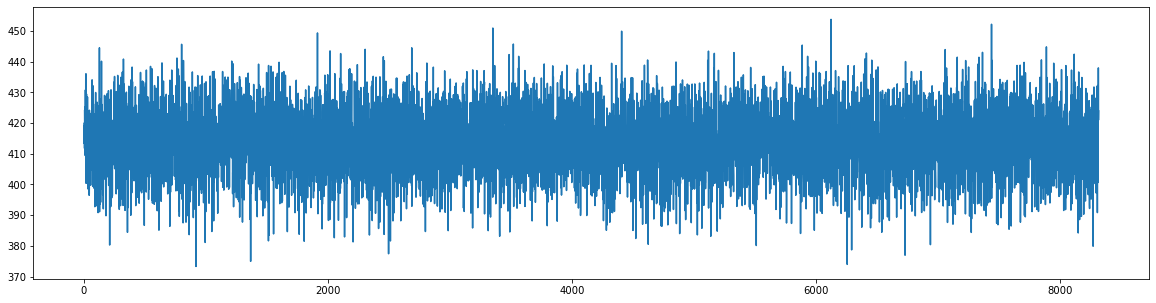

In [80]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['loss'])

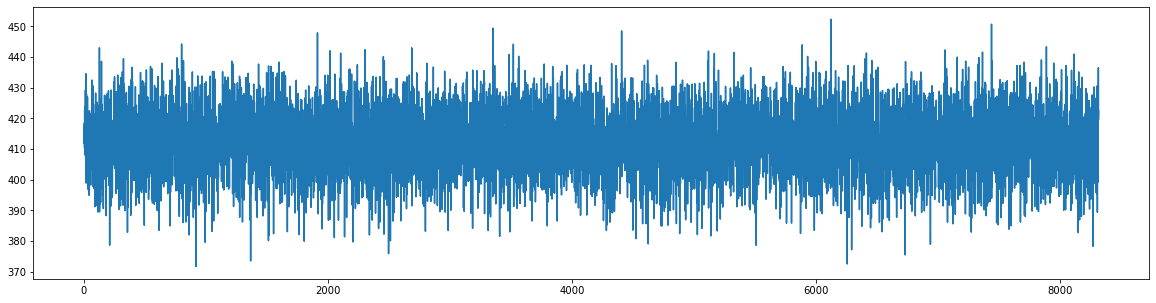

In [81]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['reconstruction_loss'])

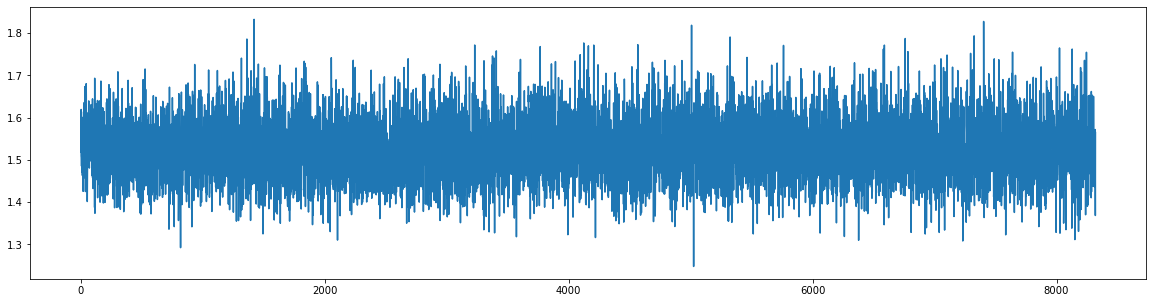

In [82]:
plt.figure(figsize=(20,5))
plt.plot(history_callback.history['kl_loss'])

predictions: 


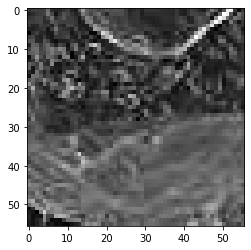

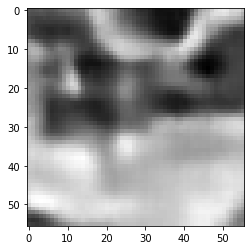

40.89715227484703

 next


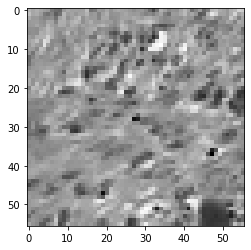

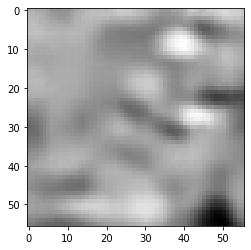

32.76754550635815

 next


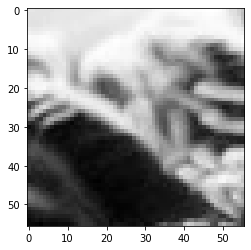

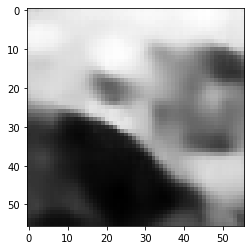

113.8108317553997

 next


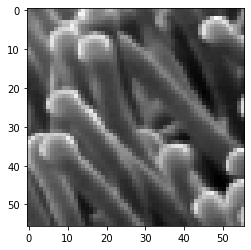

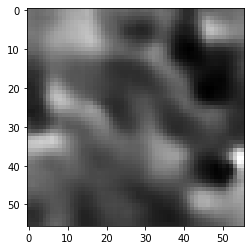

32.58194446563721

 next


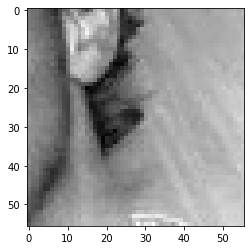

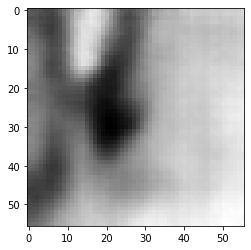

18.173203133046627

 next


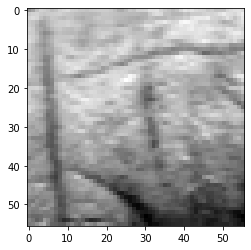

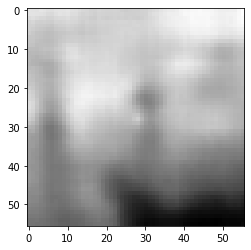

28.37284952402115

 next


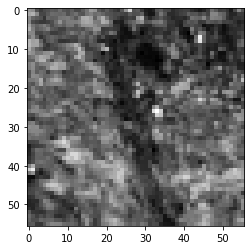

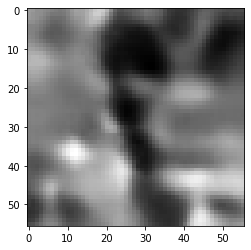

47.64377765357494

 next


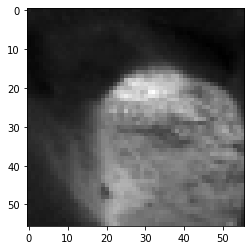

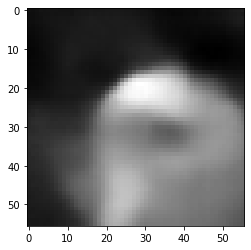

50.80577798187733

 next


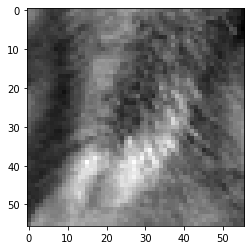

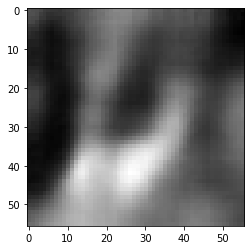

21.62399936467409

 next


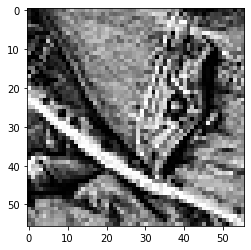

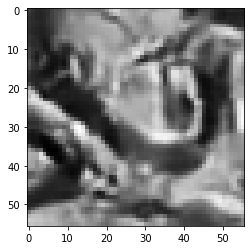

89.62772861123085

 next


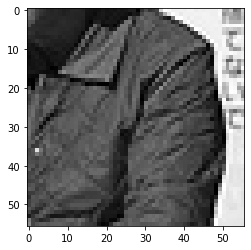

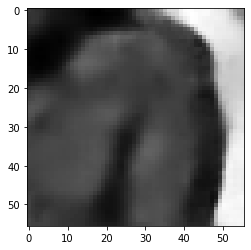

82.70978182554245

 next


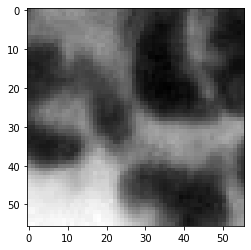

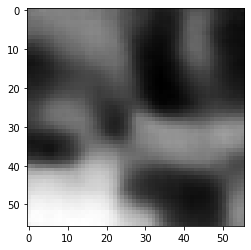

37.55903899669647

 next


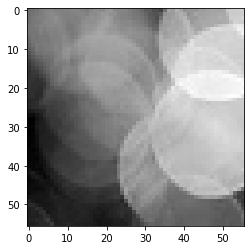

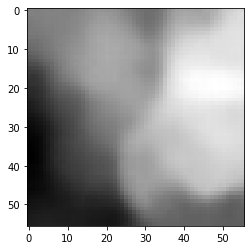

76.52018755674362

 next


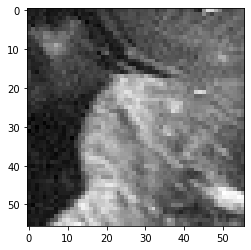

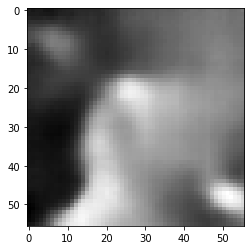

29.2947256565094

 next


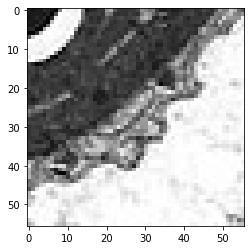

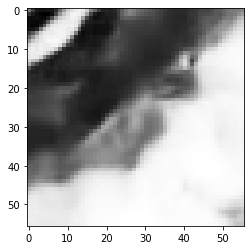

99.22690272331238

 next


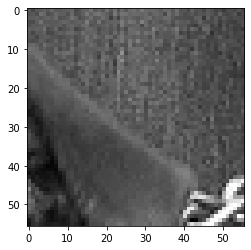

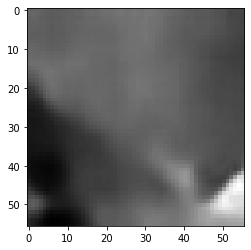

36.220454424619675

 next


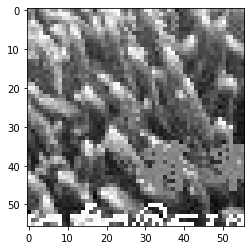

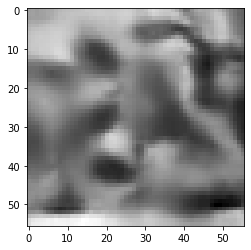

57.91999563574791

 next


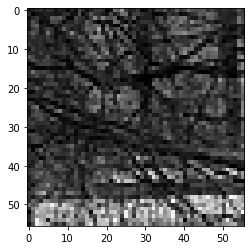

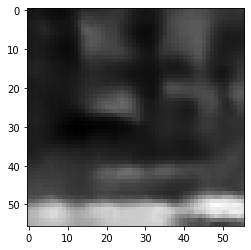

54.72977802157402

 next


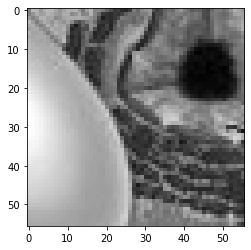

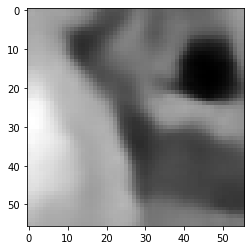

71.89434617757797

 next


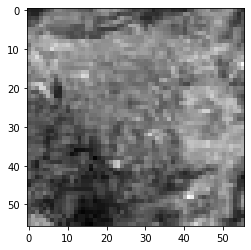

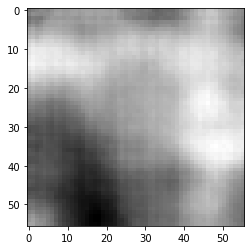

13.793521095067263

 next


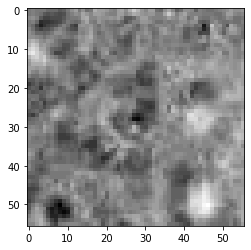

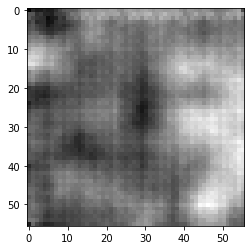

4.973929300904274

 next


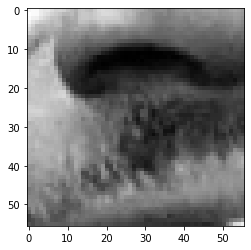

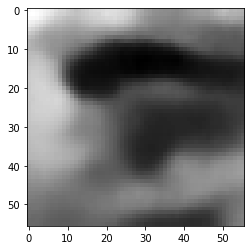

50.46470068395138

 next


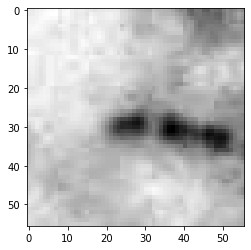

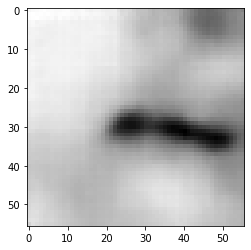

26.1850618198514

 next


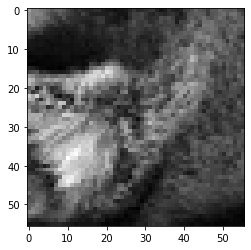

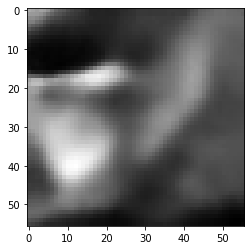

41.601471081376076

 next


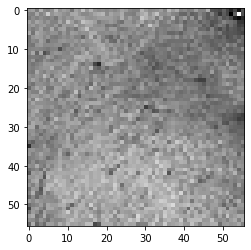

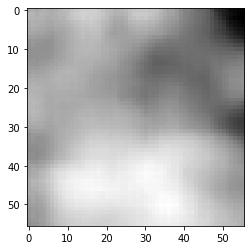

30.344168543815613

 next


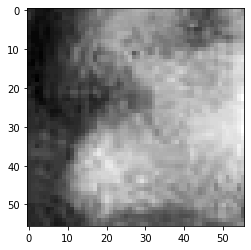

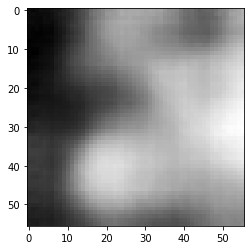

22.100681886076927

 next


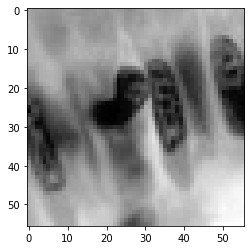

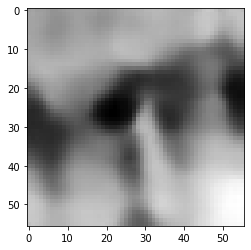

59.476996287703514

 next


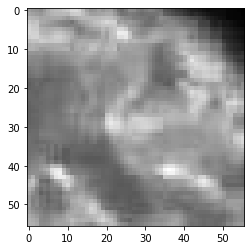

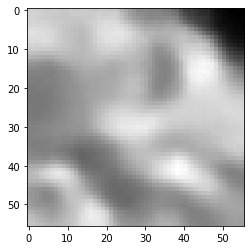

29.377986788749695

 next


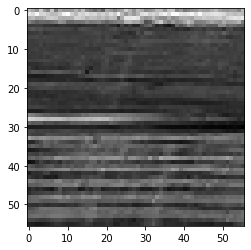

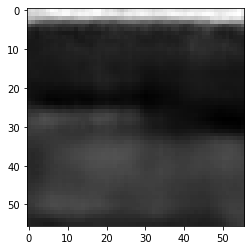

40.76200492680073

 next


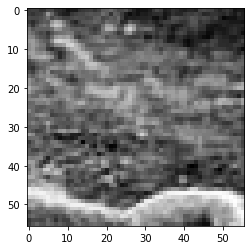

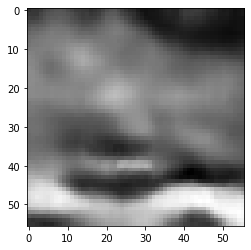

39.375976100564

 next


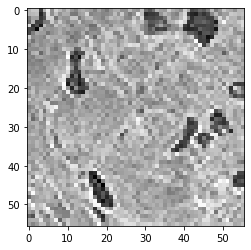

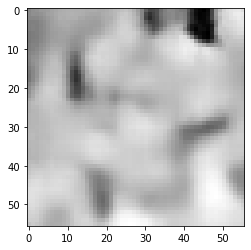

42.11510092020035

 next


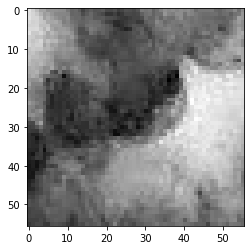

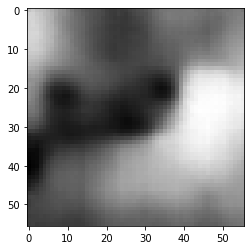

30.132783986628056

 next


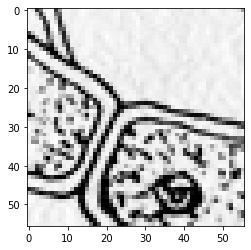

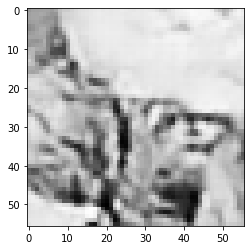

93.70661973953247

 next


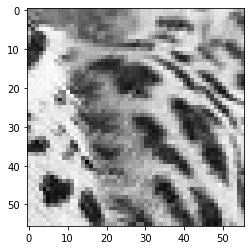

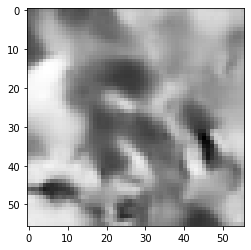

68.34843724966049

 next


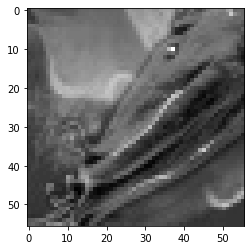

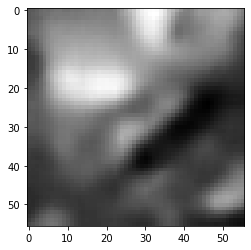

34.477256163954735

 next


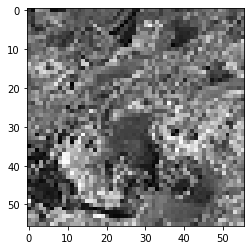

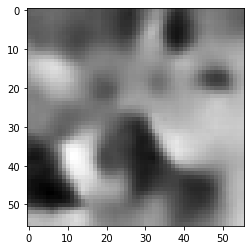

55.206812024116516

 next


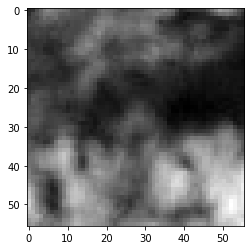

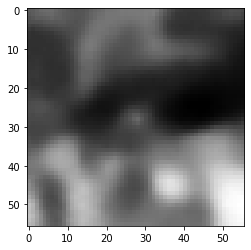

47.576369270682335

 next


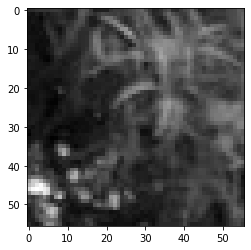

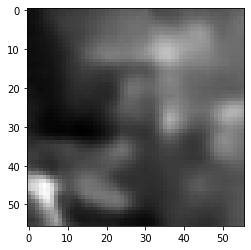

29.14072372019291

 next


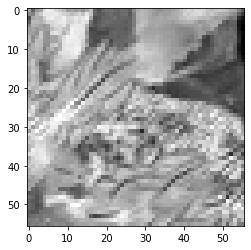

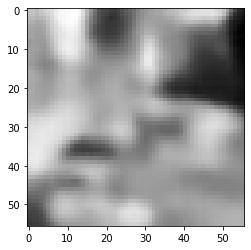

52.046605199575424

 next


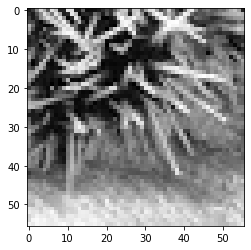

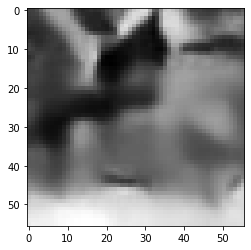

77.03946009278297

 next


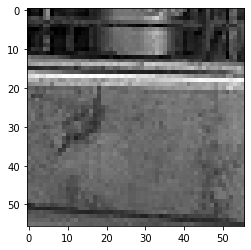

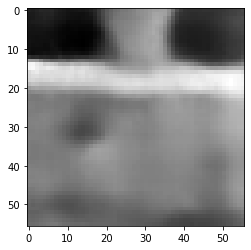

44.86211031675339

 next


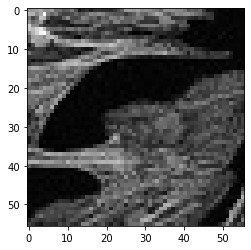

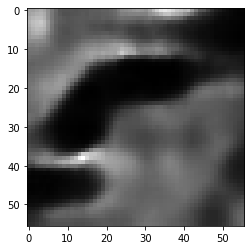

32.30598047375679

 next


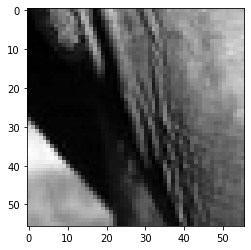

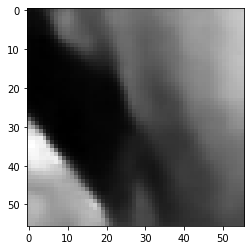

59.341955333948135

 next


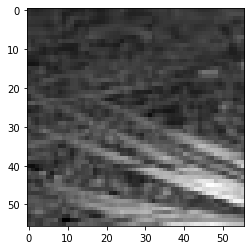

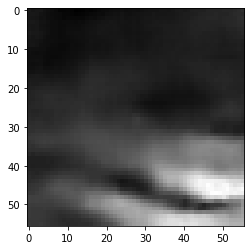

32.50391185283661

 next


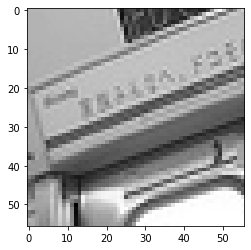

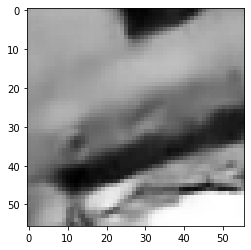

70.53660303354263

 next


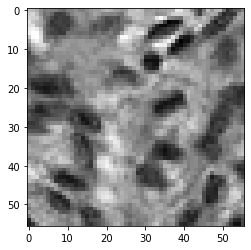

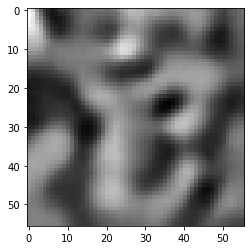

41.4666885137558

 next


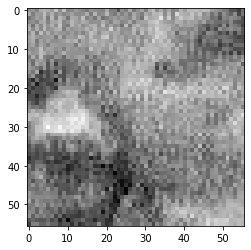

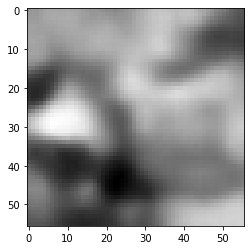

49.642459005117416

 next


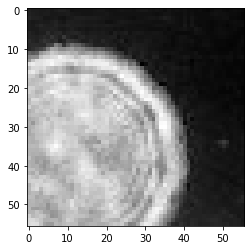

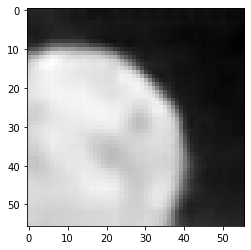

66.73783287405968

 next


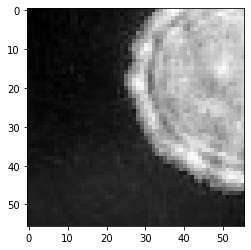

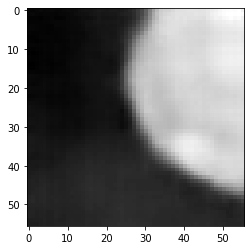

59.340754598379135

 next


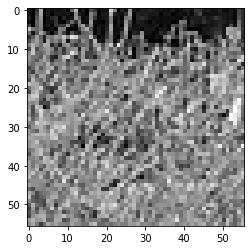

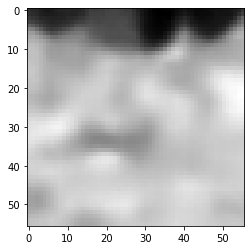

60.48943296074867

 next


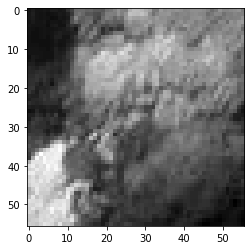

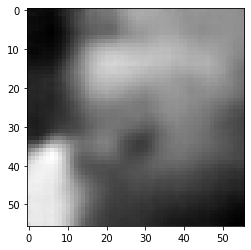

28.486936502158642

 next


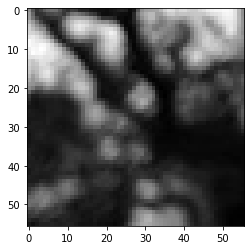

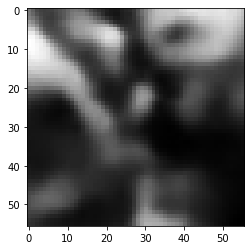

59.6401709318161

 next


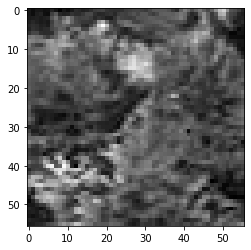

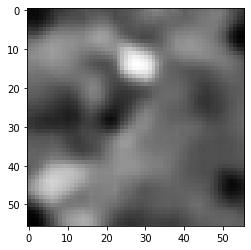

30.622161626815796

 next


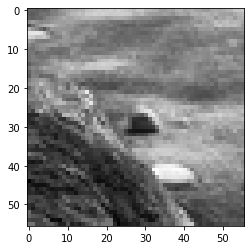

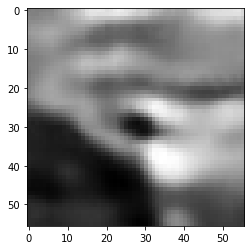

55.04005417227745

 next


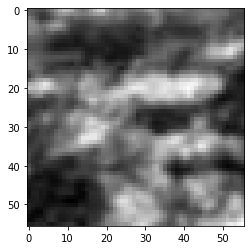

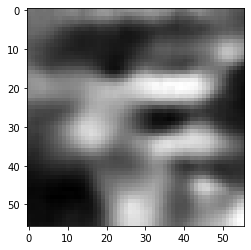

31.325769871473312

 next


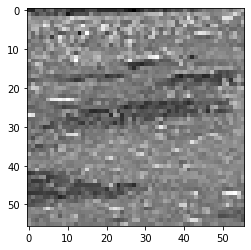

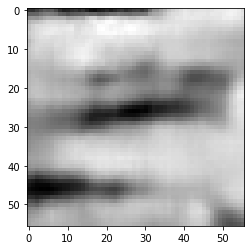

33.481170013546944

 next


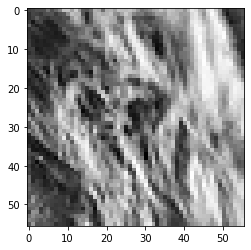

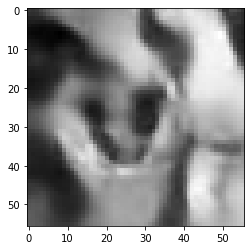

74.3202044069767

 next


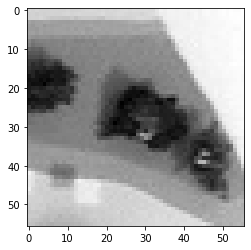

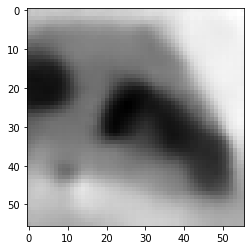

60.347009003162384

 next


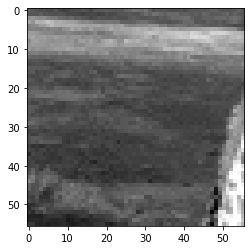

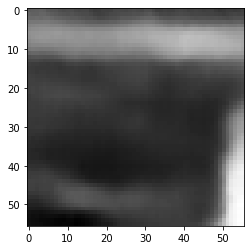

51.12447068095207

 next


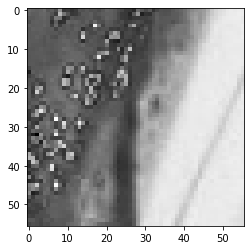

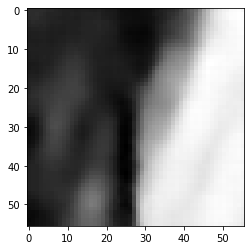

76.74172326922417

 next


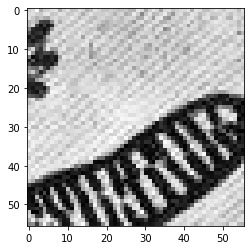

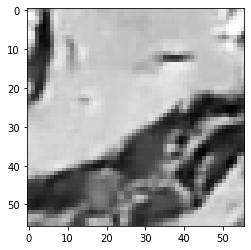

92.54456609487534

 next


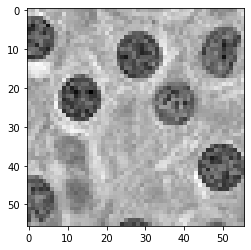

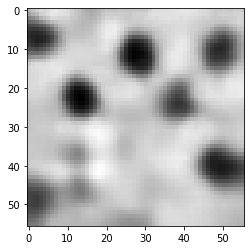

50.55838845670223

 next


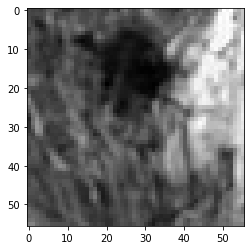

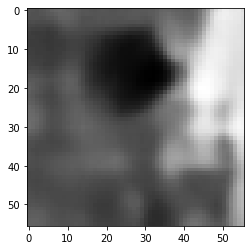

69.20200064778328

 next


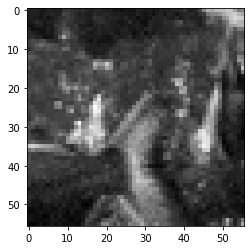

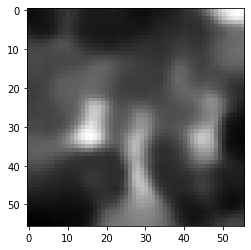

34.05708231031895

 next


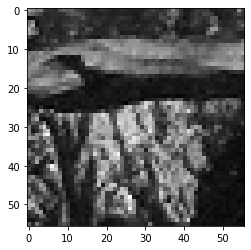

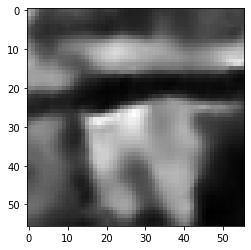

60.042846724390984

 next


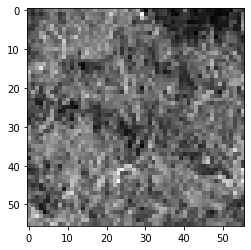

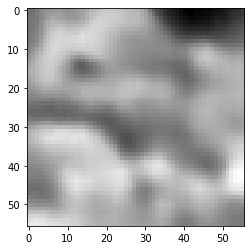

31.861216239631176

 next


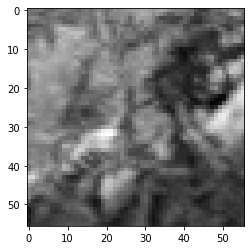

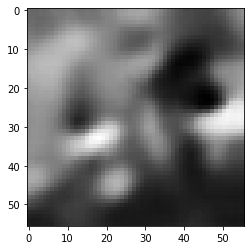

40.1951589435339

 next


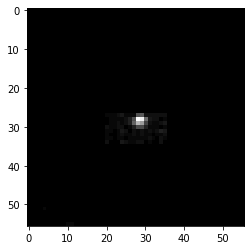

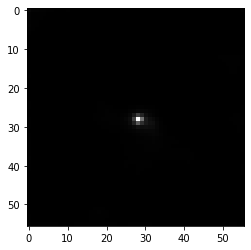

1.5311210718937218

 next


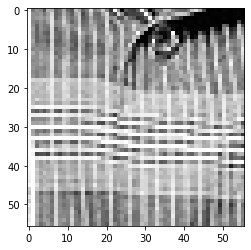

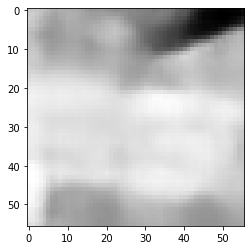

71.56681135296822

 next


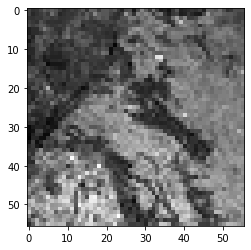

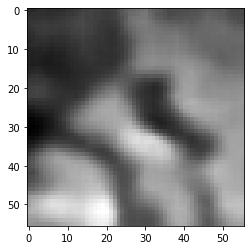

30.44856034219265

 next


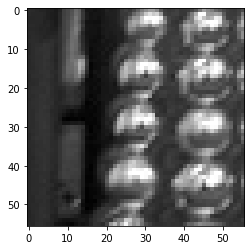

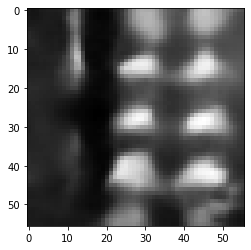

74.41325381398201

 next


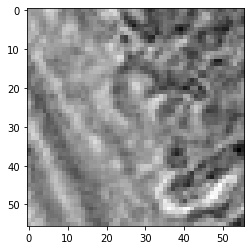

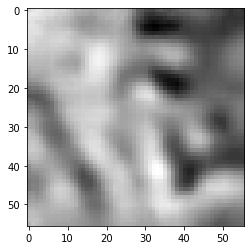

30.325980819761753

 next


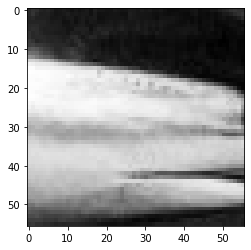

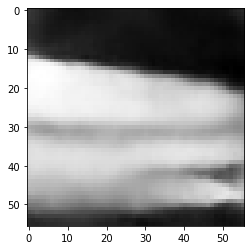

100.56551769375801

 next


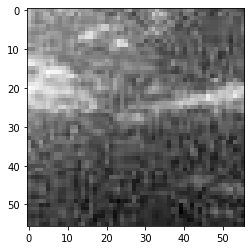

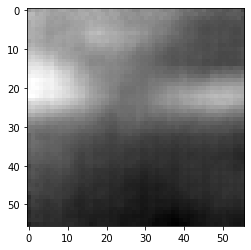

10.921463258564472

 next


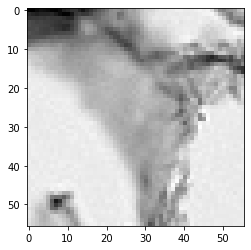

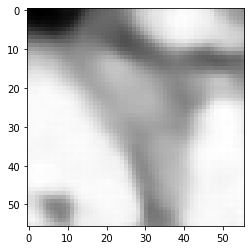

60.41649207472801

 next


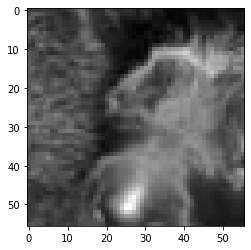

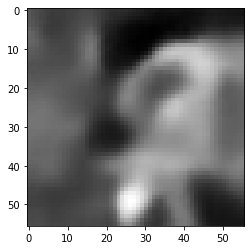

46.15816377103329

 next


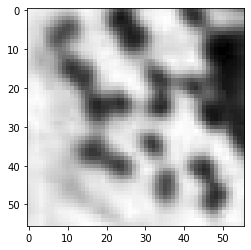

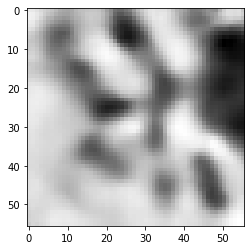

49.768255054950714

 next


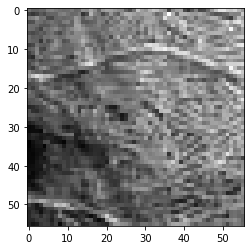

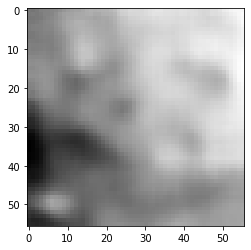

37.88846231997013

 next


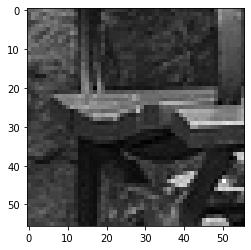

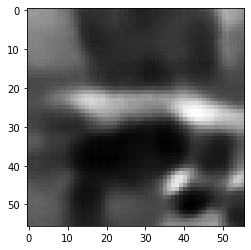

35.658677369356155

 next


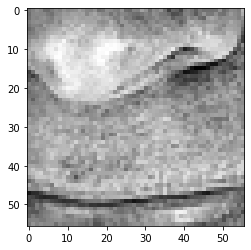

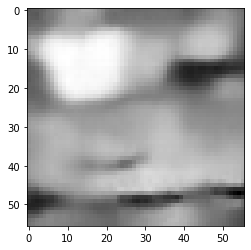

47.158270105719566

 next


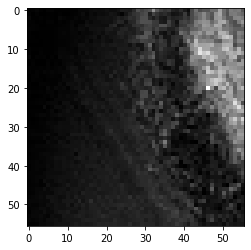

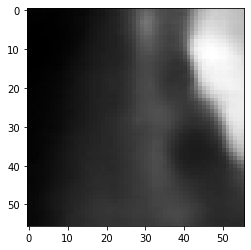

49.33953545987606

 next


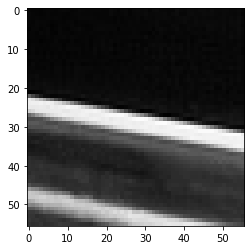

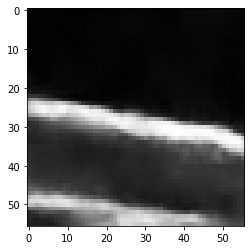

92.60860785841942

 next


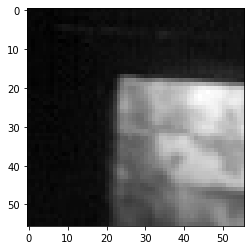

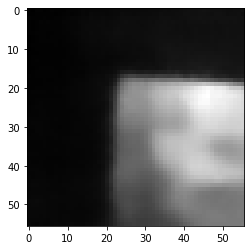

68.54663461446762

 next


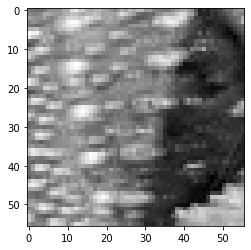

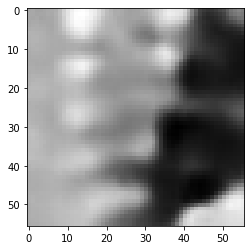

55.93112915754318

 next


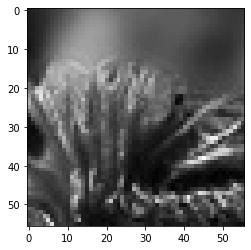

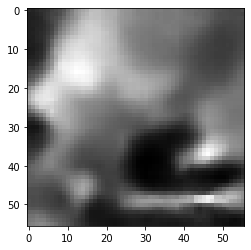

34.532831981778145

 next


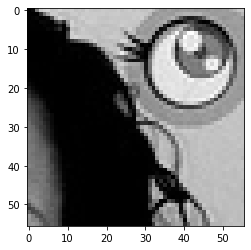

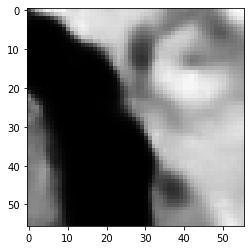

89.96410176157951

 next


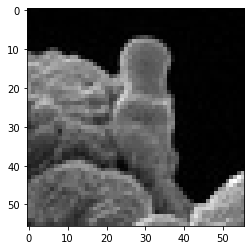

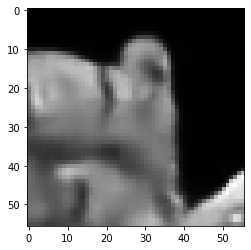

84.29571032524109

 next


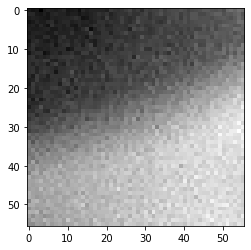

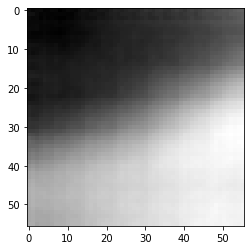

22.647578939795494

 next


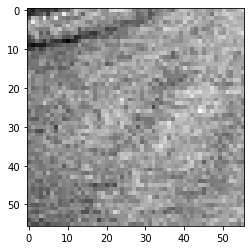

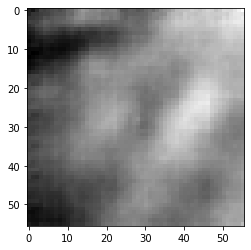

9.929592981934547

 next


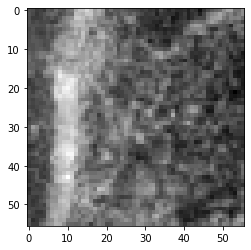

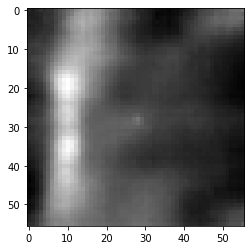

13.393501359969378

 next


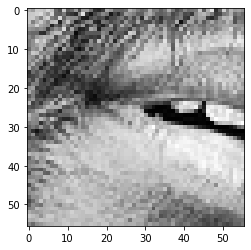

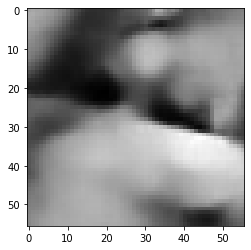

67.31757536530495

 next


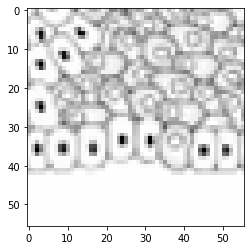

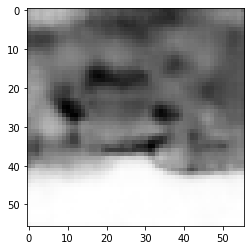

46.4627630263567

 next


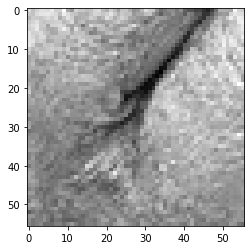

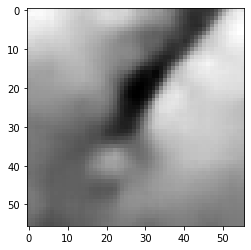

41.962022334337234

 next


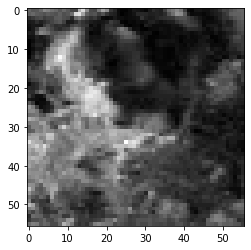

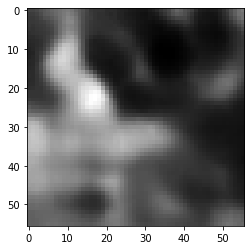

39.46414656937122

 next


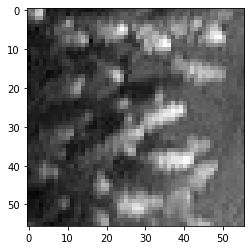

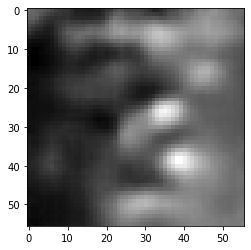

21.78300943225622

 next


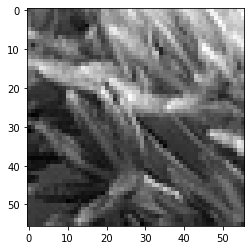

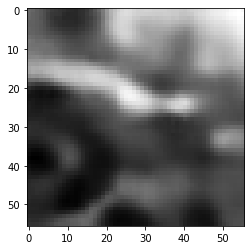

66.18351101875305

 next


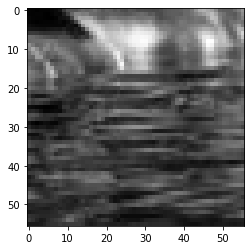

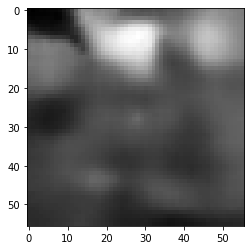

41.77658848464489

 next


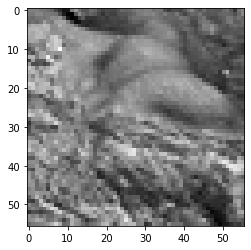

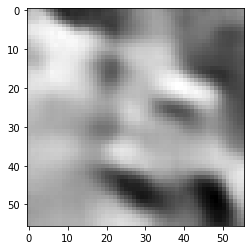

32.594282403588295

 next


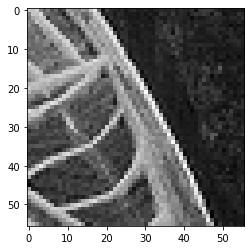

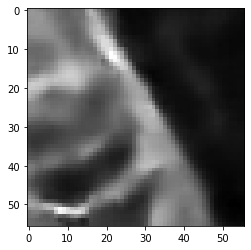

65.99800497293472

 next


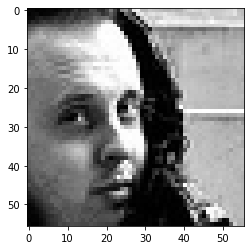

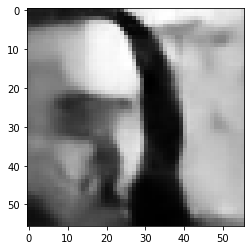

111.55030265450478

 next
0.19453128654044122


In [14]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], patch_size, patch_size, 1)
images = images / 255
predictions = decoder.predict_on_batch(encoder.predict_on_batch(np.array(images)))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape((patch_size, patch_size, 1))
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
#     ground_truth = im_1[5: 53, 5: 53, 0]
#     ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
#     plt.imshow(ground_truth[:, :], cmap='gray')
#     plt.show()
    
    
    pred_1 = predictions[i].reshape((patch_size, patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(im_1, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=50, batch_size=batch_size)


model_version = "0.0.0.3"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history_callback = vae.fit(x_train, epochs=65*batch_size, batch_size=batch_size)

model_version = "0.0.0.5"
vae.save_weights(base_dir + '/vae_' + model_version + '.h5')


Epoch 1/8320
157/505 [========>.....................] - ETA: 3s - loss: 479.8514 - reconstruction_loss: 479.1814 - kl_loss: 0.6701

KeyboardInterrupt: 